**SOCIAL MEDIA DATA ANALYSIS PROJECT**

**Gender Differences among popular musicians on Youtube and Spotify**

Research Questions:

1. Does being a female musician result in significantly lower popularity metrics (views, likes, comments and subscriber counts on YouTube and followers and popularity scores on Spotify) compared to male musicians?
2. Does being a female musician result in a more negative overall sentiment of YouTube comments compared to male musicians?


In [18]:
#! pip install vaderSentiment
#! pip install transformers
#! pip install langdetect

In [1]:
# Import the relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
from datetime import datetime, timezone
import os
import time
import googleapiclient.discovery
import googleapiclient.errors
from bs4 import BeautifulSoup
from googleapiclient.discovery import build
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import requests
import base64
import matplotlib.ticker as ticker
from scipy import stats
from scipy.stats import mannwhitneyu
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from statsmodels.stats.proportion import proportions_ztest
import ast
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import RobertaTokenizer, pipeline
from tqdm import tqdm

In [2]:
# Credentials for youtube
api_key = ''

In [3]:
# Credentials for spotify
client_id = ''
client_secret = ''

**Step 1: Get the top 20 musicians**

Get the recent top 20 global music artists based on the Youtube Charts (https://charts.youtube.com/charts/TopArtists/global/weekly) and the Spotify Charts (https://charts.spotify.com/charts/view/artist-global-weekly/latest). The Youtube Charts provide a csv file to download, the Spotify Charts are copied by hand.

In [58]:
# Load the weekly spotify charts of the last 4 weeks 
# data from https://charts.spotify.com/charts/view/artist-global-weekly/2024-07-25, https://charts.spotify.com/charts/view/artist-global-weekly/2024-07-18,
# https://charts.spotify.com/charts/view/artist-global-weekly/2024-07-11, https://charts.spotify.com/charts/view/artist-global-weekly/2024-07-04
spotify_0704 = pd.read_csv('data/charts_data/spotify-charts-top-artists-global-weekly-20240704.csv', delimiter=';', encoding='ISO-8859-1')
spotify_0711 = pd.read_csv('data/charts_data/spotify-charts-top-artists-gloabl-weekly-20240711.csv', delimiter=';', encoding='ISO-8859-1')
spotify_0718 = pd.read_csv('data/charts_data/spotify-charts-top-artists-global-weekly-20240718.csv', delimiter=';', encoding='ISO-8859-1')
spotify_0725 = pd.read_csv('data/charts_data/spotify-charts-top-artists-global-weekly-20240725.csv', delimiter=';', encoding='ISO-8859-1')

In [59]:
# Rename the columns
spotify_0704.rename(columns = {'Rank': 'Rank_Spotify_04'}, inplace = True)
spotify_0711.rename(columns = {'Rank': 'Rank_Spotify_11'}, inplace = True)
spotify_0718.rename(columns = {'Rank': 'Rank_Spotify_18'}, inplace = True)
spotify_0725.rename(columns = {'Rank': 'Rank_Spotify_25'}, inplace = True)

In [60]:
# Merge the dataframes
spotify_1 = spotify_0704.merge(spotify_0711, on = 'Artist')

In [61]:
spotify_2 = spotify_1.merge(spotify_0718, on = 'Artist')

In [62]:
spotify_2

,Rank_Spotify_04,Artist,Rank_Spotify_11,Rank_Spotify_18
0,1,Taylor Swift,1,1
1,2,Billie Eilish,2,4
2,3,Bad Bunny,3,3
3,4,The Weeknd,4,5
4,5,Peso Pluma,8,9
...,...,...,...,...
85,92,Tiësto,86,93
86,93,Grupo Frontera,83,84
87,94,Rels B,93,91
88,95,FloyyMenor,95,90


In [172]:
spotify_top_artists = spotify_2.merge(spotify_0725, on = 'Artist')

In [173]:
# Top artists spotify based on month july
spotify_top_artists 

,Rank_Spotify_04,Artist,Rank_Spotify_11,Rank_Spotify_18,Rank_Spotify_25
0,1,Taylor Swift,1,1,1
1,2,Billie Eilish,2,4,3
2,3,Bad Bunny,3,3,2
3,4,The Weeknd,4,5,5
4,5,Peso Pluma,8,9,8
...,...,...,...,...,...
84,92,Tiësto,86,93,92
85,93,Grupo Frontera,83,84,87
86,94,Rels B,93,91,96
87,95,FloyyMenor,95,90,84


In [94]:
# Save to csv
spotify_top_artists.to_csv('data/top_artists/spotify_top_artists.csv', index = False)

In [63]:
# Load the weekly youtube charts of the last 4 weeks 
# data from https://charts.youtube.com/charts/TopArtists/global/weekly/20240704, https://charts.youtube.com/charts/TopArtists/global/weekly/20240711,
# https://charts.youtube.com/charts/TopArtists/global/weekly/20240718, https://charts.youtube.com/charts/TopArtists/global/weekly/20240725 
youtube_0704 = pd.read_csv('charts_data/youtube-charts-top-artists-global-weekly-20240704.csv')
youtube_0711 = pd.read_csv('charts_data/youtube-charts-top-artists-global-weekly-20240711.csv')
youtube_0718 = pd.read_csv('charts_data/youtube-charts-top-artists-global-weekly-20240718.csv')
youtube_0725 = pd.read_csv('charts_data/youtube-charts-top-artists-global-weekly-20240725.csv')

In [146]:
# Rename the columns
youtube_0704.rename(columns = {'Rank': 'Rank_Youtube_04'}, inplace = True)
youtube_0711.rename(columns = {'Rank': 'Rank_Youtube_11'}, inplace = True)
youtube_0718.rename(columns = {'Rank': 'Rank_Youtube_18'}, inplace = True)
youtube_0725.rename(columns = {'Rank': 'Rank_Youtube_25'}, inplace = True)

In [147]:
# Drop unneeded columns
youtube_0704.drop(columns = ['Previous Rank', 'Periods on Chart', 'Views', 'Growth'], inplace = True)
youtube_0711.drop(columns = ['Previous Rank', 'Periods on Chart', 'Views', 'Growth'], inplace = True)
youtube_0718.drop(columns = ['Previous Rank', 'Periods on Chart', 'Views', 'Growth'], inplace = True)
youtube_0725.drop(columns = ['Previous Rank', 'Periods on Chart', 'Views', 'Growth'], inplace = True)

In [161]:
# Merge the dataframes
youtube_1 = youtube_0704.merge(youtube_0711, on = 'Artist')

In [162]:
youtube_2 = youtube_1.merge(youtube_0718, on = 'Artist')

In [163]:
youtube_2

,Rank_Youtube_04,Artist,Rank_Youtube_11,Rank_Youtube_18
0,1,Alka Yagnik,1,1
1,2,Udit Narayan,2,2
2,3,Arijit Singh,3,3
3,4,Kumar Sanu,4,4
4,5,Shreya Ghoshal,5,6
...,...,...,...,...
90,93,Neelkamal Singh,95,96
91,94,Alan Walker,87,94
92,96,Vicente Fernández,93,90
93,97,Michael Jackson,94,97


In [164]:
youtube_top_artists = youtube_2.merge(youtube_0725, on = 'Artist')

In [165]:
# Top artists youtube based on month july
youtube_top_artists

,Rank_Youtube_04,Artist,Rank_Youtube_11,Rank_Youtube_18,Rank_Youtube_25
0,1,Alka Yagnik,1,1,1
1,2,Udit Narayan,2,2,2
2,3,Arijit Singh,3,3,3
3,4,Kumar Sanu,4,4,4
4,5,Shreya Ghoshal,5,6,5
...,...,...,...,...,...
86,93,Neelkamal Singh,95,96,98
87,94,Alan Walker,87,94,91
88,96,Vicente Fernández,93,90,83
89,97,Michael Jackson,94,97,92


In [103]:
# Save to csv
youtube_top_artists.to_csv('top_artists/youtube_top_artists.csv', index = False)

In [174]:
# Merge the spotify and youtube top artists
merged_artists = spotify_top_artists.merge(youtube_top_artists, on = 'Artist')
merged_artists

,Rank_Spotify_04,Artist,Rank_Spotify_11,Rank_Spotify_18,Rank_Spotify_25,Rank_Youtube_04,Rank_Youtube_11,Rank_Youtube_18,Rank_Youtube_25
0,1,Taylor Swift,1,1,1,13,12,14,14
1,2,Billie Eilish,2,4,3,21,23,24,24
2,3,Bad Bunny,3,3,2,7,7,9,7
3,4,The Weeknd,4,5,5,16,17,16,15
4,5,Peso Pluma,8,9,8,9,10,11,10
5,7,Sabrina Carpenter,11,13,16,41,41,54,53
6,8,Travis Scott,9,8,7,70,68,68,64
7,9,Kendrick Lamar,7,7,10,37,16,27,31
8,10,Feid,13,14,12,20,19,19,18
9,11,Eminem,12,2,4,15,14,5,9


In [175]:
# Drop the bands
merged_artists.drop([15, 21, 30, 34, 36, 40, 46], axis = 0, inplace = True)

In [176]:
# save the merged top artists to csv
merged_artists.to_csv('top_artists/merged_top_artists.csv', index = False)

Manually label the gender for the top artists of youtube and spotify

In [64]:
# Load the labelled top artists
top_artists_gender = pd.read_csv('top_artists/merged_top_artists_gender.csv')
top_artists_gender

,Rank_Spotify_04,Artist,Rank_Spotify_11,Rank_Spotify_18,Rank_Spotify_25,Rank_Youtube_04,Rank_Youtube_11,Rank_Youtube_18,Rank_Youtube_25,Gender
0,1,Taylor Swift,1,1,1,13,12,14,14,female
1,2,Billie Eilish,2,4,3,21,23,24,24,female
2,3,Bad Bunny,3,3,2,7,7,9,7,male
3,4,The Weeknd,4,5,5,16,17,16,15,male
4,5,Peso Pluma,8,9,8,9,10,11,10,male
5,7,Sabrina Carpenter,11,13,16,41,41,54,53,female
6,8,Travis Scott,9,8,7,70,68,68,64,male
7,9,Kendrick Lamar,7,7,10,37,16,27,31,male
8,10,Feid,13,14,12,20,19,19,18,male
9,11,Eminem,12,2,4,15,14,5,9,male


In [6]:
# Check how many females and males are contained in the Charts
female_artists = top_artists_gender[top_artists_gender['Gender']=='female']
male_artists = top_artists_gender[top_artists_gender['Gender']=='male']

print('Number of female artists contained in both charts:', len(female_artists))
print('Number of male artists contained in both charts:', len(male_artists))

Number of female artists contained in both charts: 12

Number of male artists contained in both charts: 28


In [426]:
# Add up the ranks of spotify and youtube for each artist
top_artists_gender['Combined_Rank'] = (top_artists_gender['Rank_Youtube_04'] + top_artists_gender['Rank_Youtube_11'] + top_artists_gender['Rank_Youtube_18'] + top_artists_gender['Rank_Youtube_25'] 
                                           + top_artists_gender['Rank_Spotify_04'] + top_artists_gender['Rank_Spotify_11'] + top_artists_gender['Rank_Spotify_18'] + top_artists_gender['Rank_Spotify_25'])

# Sort by the combined rank
df_sorted = top_artists_gender.sort_values('Combined_Rank')

# Select top 20 ensuring equal gender distribution
top_male = df_sorted[df_sorted['Gender'] == 'male'].head(10)
top_female = df_sorted[df_sorted['Gender'] == 'female'].head(10)

# Concatenate the two lists
top_20 = pd.concat([top_male, top_female]).sort_values('Combined_Rank').reset_index(drop=True)
top_20

,Rank_Spotify_04,Artist,Rank_Spotify_11,Rank_Spotify_18,Rank_Spotify_25,Rank_Youtube_04,Rank_Youtube_11,Rank_Youtube_18,Rank_Youtube_25,Gender,Combined_Rank
0,3,Bad Bunny,3,3,2,7,7,9,7,male,41
1,1,Taylor Swift,1,1,1,13,12,14,14,female,57
2,12,Arijit Singh,14,15,13,3,3,3,3,male,66
3,5,Peso Pluma,8,9,8,9,10,11,10,male,70
4,11,Eminem,12,2,4,15,14,5,9,male,72
5,14,KAROL G,16,11,9,8,8,8,6,female,80
6,4,The Weeknd,4,5,5,16,17,16,15,male,82
7,2,Billie Eilish,2,4,3,21,23,24,24,female,103
8,10,Feid,13,14,12,20,19,19,18,male,125
9,9,Kendrick Lamar,7,7,10,37,16,27,31,male,144


In [427]:
# Drop the columns that I don't need for further analysis
top_20.drop(columns = ['Rank_Spotify_04', 'Rank_Spotify_11', 'Rank_Spotify_18', 'Rank_Spotify_25', 'Rank_Youtube_04', 'Rank_Youtube_11', 'Rank_Youtube_18', 'Rank_Youtube_25', 'Combined_Rank'], inplace = True)

In [454]:
# Identifed Top 20 global Artists and their Gender based on the YouTube and Spotify charts from the month July
top_20

,Artist,Gender
0,Bad Bunny,male
1,Taylor Swift,female
2,Arijit Singh,male
3,Peso Pluma,male
4,Eminem,male
5,KAROL G,female
6,The Weeknd,male
7,Billie Eilish,female
8,Feid,male
9,Kendrick Lamar,male


In [428]:
# Save to csv
top_20.to_csv('top_artists/top_20_artists.csv', index = False)

**Step 2: Retrieve the Popularity Metrics for each Artist from Spotify and YouTube**

Retrieve the Popularity Metrics for Spotify (Followers and Popularity measure (The popularity of the artist. The value will be between 0 and 100, with 100 being the most popular. The artist's popularity is calculated from the popularity of all the artist's tracks.(https://developer.spotify.com/documentation/web-api/reference/get-an-artist))

In [5]:
# Get the access token of Spotify
def get_access_token(client_id, client_secret):
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_headers = {
        'Authorization': 'Basic ' + base64.b64encode((client_id + ':' + client_secret).encode('utf-8')).decode('utf-8'),
    }
    auth_data = {
        'grant_type': 'client_credentials'
    }
    auth_response = requests.post(auth_url, headers=auth_headers, data=auth_data)
    auth_response_data = auth_response.json()
    return auth_response_data['access_token']

access_token = get_access_token(client_id, client_secret)

# Define the headers with the access token
headers = {
    'Authorization': f'Bearer {access_token}'
}

In [121]:
# Function to get artist ID
def get_spotify_artist_id(artist_name):
    '''
    Function to retrieve the artist id for a given artist from Spotify
    
    Parameters
    ----------
    artist_name: String
                 Name of artist for which artist ID is to be retrieved.
    
    Returns:
    ----------
    artist id: String
               Artist ID from spotify api of the given artist name
    '''
    search_url = f'https://api.spotify.com/v1/search?q={artist_name}&type=artist&limit=1'
    response = requests.get(search_url, headers=headers)
    data = response.json()
    return data['artists']['items'][0]['id'] if data['artists']['items'] else None

# Function to get artist popularity and followers
def get_spotify_artist_metrics(artist_id):
    '''
    Function to retrieve the artist's number of followers and popularity score from Spotify
    
    Parameters
    ----------
    artist_id: String
               Artist ID retrieved from Spotify API
    
    Returns:
    ----------
    popularity score: Integer
                      Popularity score on Spotify of an artist
    number of followers: Integer
                         Number of followers on Spotify of an artist
    '''
    artist_url = f'https://api.spotify.com/v1/artists/{artist_id}'
    response = requests.get(artist_url, headers=headers)
    data = response.json()
    return data['popularity'], data['followers']['total']

# Initialize lists to store the retrieved data
artist_names = []
popularity_scores = []
followers_counts = []

# Get the data for each artist
for artist in artists:
    artist_id = get_spotify_artist_id(artist)
    if artist_id:
        popularity, followers = get_spotify_artist_metrics(artist_id)
        artist_names.append(artist)
        popularity_scores.append(popularity)
        followers_counts.append(followers)
    else:
        print(f"Artist {artist} not found on Spotify")

# Create a DataFrame with the results
spotify_data = pd.DataFrame({
    'Artist': artist_names,
    'Popularity_Spotify': popularity_scores,
    'Followers_Spotify': followers_counts
})

# Show the retrieved popularity metrics for each artist from Spotify
spotify_data

,Artist,Popularity_Spotify,Followers_Spotify
0,Bad Bunny,94,83939149
1,Taylor Swift,100,116360914
2,Arijit Singh,90,116166828
3,Peso Pluma,91,15109305
4,Eminem,94,87299672
5,KAROL G,91,48699021
6,The Weeknd,93,86759591
7,Billie Eilish,94,96463697
8,Feid,91,12473265
9,Kendrick Lamar,92,31187222


In [123]:
# Save the retrieved spotify data to csv
spotify_data.to_csv('popularity_metrics/spotify_data.csv', index = False)

In [9]:
# Reopen the spotify data
spotify_data = pd.read_csv('popularity_metrics/spotify_data.csv')
spotify_data

,Artist,Popularity_Spotify,Followers_Spotify
0,Bad Bunny,94,83939149
1,Taylor Swift,100,116360914
2,Arijit Singh,90,116166828
3,Peso Pluma,91,15109305
4,Eminem,94,87299672
5,KAROL G,91,48699021
6,The Weeknd,93,86759591
7,Billie Eilish,94,96463697
8,Feid,91,12473265
9,Kendrick Lamar,92,31187222


In [429]:
# Merge the spotify data with the Top 20 artists to get the gender
top_20_popularity = top_20.merge(spotify_data, on= 'Artist')

In [430]:
# Display the DataFrame
top_20_popularity

,Artist,Gender,Popularity_Spotify,Followers_Spotify
0,Bad Bunny,male,94,83939149
1,Taylor Swift,female,100,116360914
2,Arijit Singh,male,90,116166828
3,Peso Pluma,male,91,15109305
4,Eminem,male,94,87299672
5,KAROL G,female,91,48699021
6,The Weeknd,male,93,86759591
7,Billie Eilish,female,94,96463697
8,Feid,male,91,12473265
9,Kendrick Lamar,male,92,31187222


In [431]:
# Save to csv
top_20_popularity.to_csv('popularity_metrics/top_20_popularity.csv', index = False)

In [65]:
# Reopen the data
top_20_popularity = pd.read_csv('popularity_metrics/top_20_popularity.csv')

Retrieve the Popularity Metrics for YouTube (number of channel subscribers, channel views and number of views, likes and comments for all videos)

In [149]:
# Initialize the YouTube API client
youtube = build('youtube', 'v3', developerKey=api_key)

# Get the Channel IDs for all artists
# Function to get YouTube channel ID
def get_youtube_channel_id(youtube, artist_name):
    '''
    Function to retrieve the channel id for a given artist from YouTube
    
    Parameters
    ----------
    youtube: YouTube Api client
             An authenticated YouTube Data API client object created using build().
    artist_name: String
                 Name of artist for which channel id is to be retrieved.
    
    Returns:
    ----------
    channel_id: String
                Channel ID for the given artist name retrieved by the youtube api
    '''
    search_response = youtube.search().list(
        q=artist_name,
        part='snippet',
        type='channel',
        maxResults=1
    ).execute()

    if search_response['items']:
        channel_id = search_response['items'][0]['id']['channelId']
        return channel_id
    
    return None

# Initialize lists to store the retrieved data
artist_names_youtube = []
youtube_channel_ids = []

# Get the data for each artist
for artist in artists:
    channel_id = get_youtube_channel_id(youtube, artist)
    if channel_id:
        artist_names_youtube.append(artist)
        youtube_channel_ids.append(channel_id)
    else:
        print(f"Artist {artist} not found on YouTube")
        artist_names_youtube.append(artist)
        youtube_channel_ids.append(None)

# Create a DataFrame with the results
youtube_channel_ids_df = pd.DataFrame({
    'Artist': artist_names_youtube,
    'YouTube_Channel_ID': youtube_channel_ids
})

# Display the retrieved channel ids
youtube_channel_ids_df

,Artist,YouTube_Channel_ID
0,Bad Bunny,UCmBA_wu8xGg1OfOkfW13Q0Q
1,Taylor Swift,UCqECaJ8Gagnn7YCbPEzWH6g
2,Arijit Singh,UCDxKh1gFWeYsqePvgVzmPoQ
3,Peso Pluma,UCzrM_068Odho89mTRrrxqbA
4,Eminem,UCfM3zsQsOnfWNUppiycmBuw
5,KAROL G,UCZuPJZ2kGFdlbQu1qotZaHw
6,The Weeknd,UC0WP5P-ufpRfjbNrmOWwLBQ
7,Billie Eilish,UCiGm_E4ZwYSHV3bcW1pnSeQ
8,Feid,UCoMlNw7o21I7LqL4OsjSYAg
9,Kendrick Lamar,UC3lBXcrKFnFAFkfVk5WuKcQ


In [152]:
# For two channels I got the wrong channel id because there are multiple creators with the same name so I adjusted it manually
channel_usernames = ['@Official_ArijitSingh', 'pritam7415'] # Correct usenames
youtube_channel_ids_corrected = []

# Get the correct channel IDs for the corrected usernames
for username in channel_usernames:
    channel_id = get_youtube_channel_id(youtube, username)
    if channel_id:
        youtube_channel_ids_corrected.append(channel_id)
    else:
        print(f"Channel '{username}' not found on YouTube")
        youtube_channel_ids_corrected.append(None)

# Create a DataFrame with the results
youtube_channel_ids_corrected = pd.DataFrame({
    'Username': channel_usernames,
    'YouTube_Channel_ID': youtube_channel_ids_corrected
})

youtube_channel_ids_corrected 

,Username,YouTube_Channel_ID
0,@Official_ArijitSingh,UCtFOW7jJXChfFNoucRFqRmw
1,pritam7415,UCFrjzbol2Zy-FaKaCIKIDVA


In [153]:
# Change the channel id to the correct id
# Map the corrected channel IDs to the original artist names
corrections = {
    'Arijit Singh': youtube_channel_ids_corrected.loc[youtube_channel_ids_corrected['Username'] == '@Official_ArijitSingh', 'YouTube_Channel_ID'].values[0],
    'Pritam': youtube_channel_ids_corrected.loc[youtube_channel_ids_corrected['Username'] == 'pritam7415', 'YouTube_Channel_ID'].values[0]
}

# Update the DataFrame with corrected channel IDs
for artist, corrected_id in corrections.items():
    youtube_channel_ids_df.loc[youtube_channel_ids_df['Artist'] == artist, 'YouTube_Channel_ID'] = corrected_id
    
youtube_channel_ids_df

,Artist,YouTube_Channel_ID
0,Bad Bunny,UCmBA_wu8xGg1OfOkfW13Q0Q
1,Taylor Swift,UCqECaJ8Gagnn7YCbPEzWH6g
2,Arijit Singh,UCtFOW7jJXChfFNoucRFqRmw
3,Peso Pluma,UCzrM_068Odho89mTRrrxqbA
4,Eminem,UCfM3zsQsOnfWNUppiycmBuw
5,KAROL G,UCZuPJZ2kGFdlbQu1qotZaHw
6,The Weeknd,UC0WP5P-ufpRfjbNrmOWwLBQ
7,Billie Eilish,UCiGm_E4ZwYSHV3bcW1pnSeQ
8,Feid,UCoMlNw7o21I7LqL4OsjSYAg
9,Kendrick Lamar,UC3lBXcrKFnFAFkfVk5WuKcQ


In [155]:
# Save the channel ids to csv
youtube_channel_ids_df.to_csv('popularity_metrics/youtube_channel_ids.csv', index=False)

In [41]:
# Retrieve the popularity metrics for YouTube
logging.basicConfig(level=logging.INFO)


# Function to get YouTube channel statistics
def get_youtube_channel_stats(youtube, channel_id):
    '''
    Function to retrieve the channel statistics for a given YouTube channel.
    
    Parameters
    ----------
    youtube: Google API client
             An authenticated YouTube Data API client object.
    channel_id: String
                ID of the YouTube channel for which statistics are to be retrieved.
    
    Returns
    -------
    view_count: Integer
                Total number of views for the channel.
    subscriber_count: Integer
                      Total number of subscribers to the channel.
    video_count: Integer
                 Total number of videos on the channel.
    '''
    channel_response = youtube.channels().list(
        part='statistics',
        id=channel_id
    ).execute()
    
    if channel_response['items']:
        stats = channel_response['items'][0]['statistics']
        view_count = int(stats.get('viewCount', 0))
        subscriber_count = int(stats.get('subscriberCount', 0))
        video_count = int(stats.get('videoCount', 0))
        return view_count, subscriber_count, video_count
    
    return None, None, None

# Function to retrieve all videos for a given channel ID
def get_all_videos_for_channel(channel_id, youtube):
    '''
    Function to retrieve all videos for a given YouTube channel, including detailed statistics for each video.
    
    Parameters
    ----------
    channel_id: String
                Channel ID of the YouTube channel from which videos are to be retrieved.
    youtube: Google API client
             An authenticated YouTube Data API client object.
    
    Returns
    -------
    videos: List of Dictionaries
            Each containing detailed information about a video:
                - YouTube_Channel_ID: String, the channel ID of the video.
                - video_id: String, the ID of the video.
                - view_count: Integer, the number of views for the video.
                - like_count: Integer, the number of likes for the video.
                - comment_count: Integer, the number of comments on the video.
                - video_title: String, the title of the video.
                - release_date: String, the release date of the video.
    '''
    videos = []
    next_page_token = None
    retries = 5  
    
    while True:
        try:
            request = youtube.search().list(
                part='id,snippet',
                channelId=channel_id,
                maxResults=50,
                order='date',
                pageToken=next_page_token,
                type='video'
            )
            
            response = request.execute()
            
            video_ids = [item['id']['videoId'] for item in response['items']]
            
            for video_id in video_ids:
                video_stats = get_youtube_video_stats(video_id, youtube)
                videos.append({
                    'YouTube_Channel_ID': channel_id,
                    'video_id': video_id,
                    'view_count': int(video_stats['statistics'].get('viewCount', 0)),
                    'like_count': int(video_stats['statistics'].get('likeCount', 0)),
                    'comment_count': int(video_stats['statistics'].get('commentCount', 0)),
                    'video_title': video_stats['snippet']['title'],
                    'release_date': video_stats['snippet']['publishedAt']
                })
            
            logging.info(f"Retrieved {len(video_ids)} videos in this batch.")
            next_page_token = response.get('nextPageToken')
            
            if not next_page_token:
                break

        except Exception as e:
            retries -= 1
            if retries == 0:
                print(f"Failed to retrieve videos for channel {channel_id}: {e}")
                break
            time.sleep(10) 
            
    logging.info(f"Total videos retrieved for channel {channel_id}: {len(videos)}")
    return videos

# Function to retrieve video statistics (likes, comments) for a given video ID
def get_youtube_video_stats(video_id, youtube):
    '''
    Function to retrieve video statistics for a given YouTube video.
    
    Parameters
    ----------
    video_id: String
              Video ID of the video for which statistics are to be retrieved.
    youtube: Google API client
             An authenticated YouTube Data API client object.
    
    Returns
    -------
    response: Dictionary
              Containing video statistics and metadata:
                - statistics: Dictionary with video statistics (view count, like count, comment count).
                - snippet: Dictionary with video metadata (title, published date).
    '''
    request = youtube.videos().list(
        part='statistics,snippet',
        id=video_id
    )
    response = request.execute()
    return response['items'][0]


# Initialize YouTube API service
youtube = build('youtube', 'v3', developerKey=api_key)

# Read the CSV file with channel IDs
youtube_channel_data = pd.read_csv('data/youtube_channel_ids.csv')
# Convert the channel ids to a list
youtube_channel_ids = youtube_channel_data['YouTube_Channel_ID'].tolist()

# Initialize lists to store the retrieved data
view_counts = []
subscriber_counts = []
video_counts = []
all_videos = []

# Get the data for each channel
for channel_id in youtube_channel_ids:
    view_count, subscriber_count, video_count = get_youtube_channel_stats(youtube, channel_id)
    view_counts.append(view_count)
    subscriber_counts.append(subscriber_count)
    video_counts.append(video_count)

    # Collecting all videos for each channel ID
    videos = get_all_videos_for_channel(channel_id, youtube)
    all_videos.extend(videos)

# Add the metrics to the DataFrame
youtube_channel_data['View_Count_Youtube'] = view_counts
youtube_channel_data['Subscriber_Count_Youtube'] = subscriber_counts
youtube_channel_data['Video_Count_Youtube'] = video_counts

# Convert collected videos to DataFrame
youtube_video_data = pd.DataFrame(all_videos)

# Merge the video statistics with the artists on channel id
youtube_statistics_merged = youtube_video_data.merge(youtube_channel_data, on='YouTube_Channel_ID')

# Group the data by the artist
youtube_data = youtube_statistics_merged.groupby('Artist').agg({
    'YouTube_Channel_ID': 'first', 
    'view_count': 'sum',
    'like_count': 'sum',
    'comment_count': 'sum',
    'video_id': 'count',
    'View_Count_Youtube': 'first',
    'Subscriber_Count_Youtube': 'first',
    'Video_Count_Youtube': 'first',
}).reset_index()

# Rename columns based on actual DataFrame structure
youtube_data.columns = [
    'Artist', 
    'YouTube_Channel_ID', 
    'total_video_view_count', 
    'total_video_like_count', 
    'total_video_comment_count', 
    'number_of_videos', 
    'channel_view_count', 
    'subscriber_count', 
    'channel_video_count'
]

# Show the retrieved popularity metrics for each artist from YouTube
print(youtube_data)

INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0















INFO:root:Retrieved 50 videos in this batch.















INFO:root:Retrieved 50 videos in this batch.















INFO:root:Retrieved 50 videos in this batch.















INFO:root:Retrieved 4 videos in this batch.















INFO:root:Total videos retrieved for channel UCmBA_wu8xGg1OfOkfW13Q0Q: 154















INFO:root:Retrieved 50 videos in this batch.















INFO:root:Retrieved 50 videos in this batch.















INFO:root:Retrieved 50 videos in this batch.















INFO:root:Retrieved 50 videos in this batch.















INFO:root:Retrieved 50 videos in this batch.















INFO:root:Retrieved 16 videos in this batch.















INFO:root:Total videos retrieved for channel UCqECaJ8Gagnn7YCbPEzWH6g: 266















INFO:root:Retrieved 50 videos in this batch.















INFO:root:Retrieved 50 videos in this batch.













               Artist        YouTube_Channel_ID  total_video_view_count  \















0            Anuel AA  UCRI7hheejBbWS6etTNwMT0g              9244937181   















1       Ariana Grande  UC9CoOnJkIBMdeijd9qYoT_g              1203364400   















2        Arijit Singh  UCtFOW7jJXChfFNoucRFqRmw                81216010   















3           Bad Bunny  UCmBA_wu8xGg1OfOkfW13Q0Q             28690369803   















4       Billie Eilish  UCiGm_E4ZwYSHV3bcW1pnSeQ              1831180241   















5            Dua Lipa  UC-J-KZfRV8c13fOCkhXdLiQ             11899202661   















6              Eminem  UCfM3zsQsOnfWNUppiycmBuw              1791643695   















7                Feid  UCoMlNw7o21I7LqL4OsjSYAg                81643068   















8            Junior H  UCRRmSKkhOKEO6vIBaxG-ejA               532211456   















9             KAROL G  UCZuPJZ2kGFdlbQu1qotZaHw              1485591820   















10     Ken

Note: For some channels there is a discrepancy in the number_of_videos retrieved from the video endpoint and the channel_video_count retrieved from the channel endpoint. I tried multiple times & things to get the same number of videos but it didn't work. Online I found that YouTube counts also unlisted or private videos in the number of videos, and they can not be retrieved by the API. The API only provides the videos I could retrieve. For consistency going on I will use the number of videos retrieved from the video endpoint as that corresponds to the videos I retrieved.

In [178]:
# Calculate the averages per video
youtube_data['average_video_view_count'] = youtube_data['total_video_view_count']/youtube_data['number_of_videos']
youtube_data['average_video_like_count'] = youtube_data['total_video_view_count']/youtube_data['number_of_videos']
youtube_data['average_video_comment_count'] = youtube_data['total_video_comment_count']/youtube_data['number_of_videos']
youtube_data

,Artist,YouTube_Channel_ID,total_video_view_count,total_video_like_count,total_video_comment_count,number_of_videos,channel_view_count,subscriber_count,channel_video_count,average_video_view_count,average_video_like_count,average_video_comment_count
0,Anuel AA,UCRI7hheejBbWS6etTNwMT0g,9244937181,65695130,2594825,163,17729777247,26900000,163,5.671741e+07,5.671741e+07,15919.171779
1,Ariana Grande,UC9CoOnJkIBMdeijd9qYoT_g,1203364400,29698023,1453477,199,26478361236,54400000,201,6.047057e+06,6.047057e+06,7303.904523
2,Arijit Singh,UCtFOW7jJXChfFNoucRFqRmw,81216010,1479036,85720,122,2872505581,4200000,122,6.657050e+05,6.657050e+05,702.622951
3,Bad Bunny,UCmBA_wu8xGg1OfOkfW13Q0Q,28690369803,216147850,5444822,154,35720519502,48000000,155,1.863011e+08,1.863011e+08,35355.987013
4,Billie Eilish,UCiGm_E4ZwYSHV3bcW1pnSeQ,1831180241,58722769,1588676,127,16211660838,52400000,127,1.441874e+07,1.441874e+07,12509.259843
5,Dua Lipa,UC-J-KZfRV8c13fOCkhXdLiQ,11899202661,105772965,2307367,273,13450948905,23700000,279,4.358682e+07,4.358682e+07,8451.893773
6,Eminem,UCfM3zsQsOnfWNUppiycmBuw,1791643695,29000498,1543653,187,30661681457,61300000,190,9.580982e+06,9.580982e+06,8254.828877
7,Feid,UCoMlNw7o21I7LqL4OsjSYAg,81643068,1656778,40830,140,7782628514,6250000,139,5.831648e+05,5.831648e+05,291.642857
8,Junior H,UCRRmSKkhOKEO6vIBaxG-ejA,532211456,3111149,42663,23,3994231605,2330000,23,2.313963e+07,2.313963e+07,1854.913043
9,KAROL G,UCZuPJZ2kGFdlbQu1qotZaHw,1485591820,23772087,510592,160,24625878735,37300000,161,9.284949e+06,9.284949e+06,3191.200000


In [179]:
# Save the Youtube data to csv
youtube_data.to_csv('popularity_metrics/youtube_data.csv', index = False)

In [213]:
# Save the Youtube video data to csv
youtube_video_data.to_csv('popularity_metrics/youtube_video_data.csv', index = False)

In [66]:
# Reopen the YouTube data
youtube_data = pd.read_csv('popularity_metrics/youtube_data.csv')

In [435]:
# Merge the spotify popularity metrics with the youtube popularity metrics
popularity_metrics = youtube_data.merge(top_20_popularity, on = 'Artist')
popularity_metrics.drop(columns = {'channel_video_count', 'YouTube_Channel_ID'}, inplace = True)

In [436]:
# Show the retrieved popularity metrics for all artists from Spotify and YouTube
popularity_metrics

,Artist,total_video_view_count,total_video_like_count,total_video_comment_count,number_of_videos,channel_view_count,subscriber_count,average_video_view_count,average_video_like_count,average_video_comment_count,Gender,Popularity_Spotify,Followers_Spotify
0,Anuel AA,9244937181,65695130,2594825,163,17729777247,26900000,5.671741e+07,5.671741e+07,15919.171779,male,88,36575365
1,Ariana Grande,1203364400,29698023,1453477,199,26478361236,54400000,6.047057e+06,6.047057e+06,7303.904523,female,91,97830570
2,Arijit Singh,81216010,1479036,85720,122,2872505581,4200000,6.657050e+05,6.657050e+05,702.622951,male,90,116166828
3,Bad Bunny,28690369803,216147850,5444822,154,35720519502,48000000,1.863011e+08,1.863011e+08,35355.987013,male,94,83939149
4,Billie Eilish,1831180241,58722769,1588676,127,16211660838,52400000,1.441874e+07,1.441874e+07,12509.259843,female,94,96463697
5,Dua Lipa,11899202661,105772965,2307367,273,13450948905,23700000,4.358682e+07,4.358682e+07,8451.893773,female,89,44088203
6,Eminem,1791643695,29000498,1543653,187,30661681457,61300000,9.580982e+06,9.580982e+06,8254.828877,male,94,87299672
7,Feid,81643068,1656778,40830,140,7782628514,6250000,5.831648e+05,5.831648e+05,291.642857,male,91,12473265
8,Junior H,532211456,3111149,42663,23,3994231605,2330000,2.313963e+07,2.313963e+07,1854.913043,male,89,17502312
9,KAROL G,1485591820,23772087,510592,160,24625878735,37300000,9.284949e+06,9.284949e+06,3191.200000,female,91,48699021


In [437]:
# Rename columns for clarity
popularity_metrics.rename(columns = {'total_video_view_count': 'Total_Video_Views_Youtube', 
                                     'total_video_like_count': 'Total_Video_Likes_Youtube', 
                                     'total_video_comment_count': 'Total_Video_Comments_Youtube', 
                                     'number_of_videos': 'Number_Of_Videos_Youtube', 
                                     'channel_view_count': 'Channel_Views_Youtube', 
                                     'subscriber_count': 'Subscribers_Youtube', 
                                     'average_video_view_count': 'Average_Video_Views_Youtube', 
                                     'average_video_like_count': 'Average_Video_Likes_Youtube', 
                                     'average_video_comment_count': 'Average_Video_Comments_Youtube'}, inplace = True)

In [438]:
# Save the popularity metrics to csv
popularity_metrics.to_csv('popularity_metrics/popularity_metrics_youtube_spotify.csv', index = False)

In [67]:
# Reopen the popularity metrics
popularity_metrics = pd.read_csv('popularity_metrics/popularity_metrics_youtube_spotify.csv')

**Step 3: Visualize the Popularity Metrics**

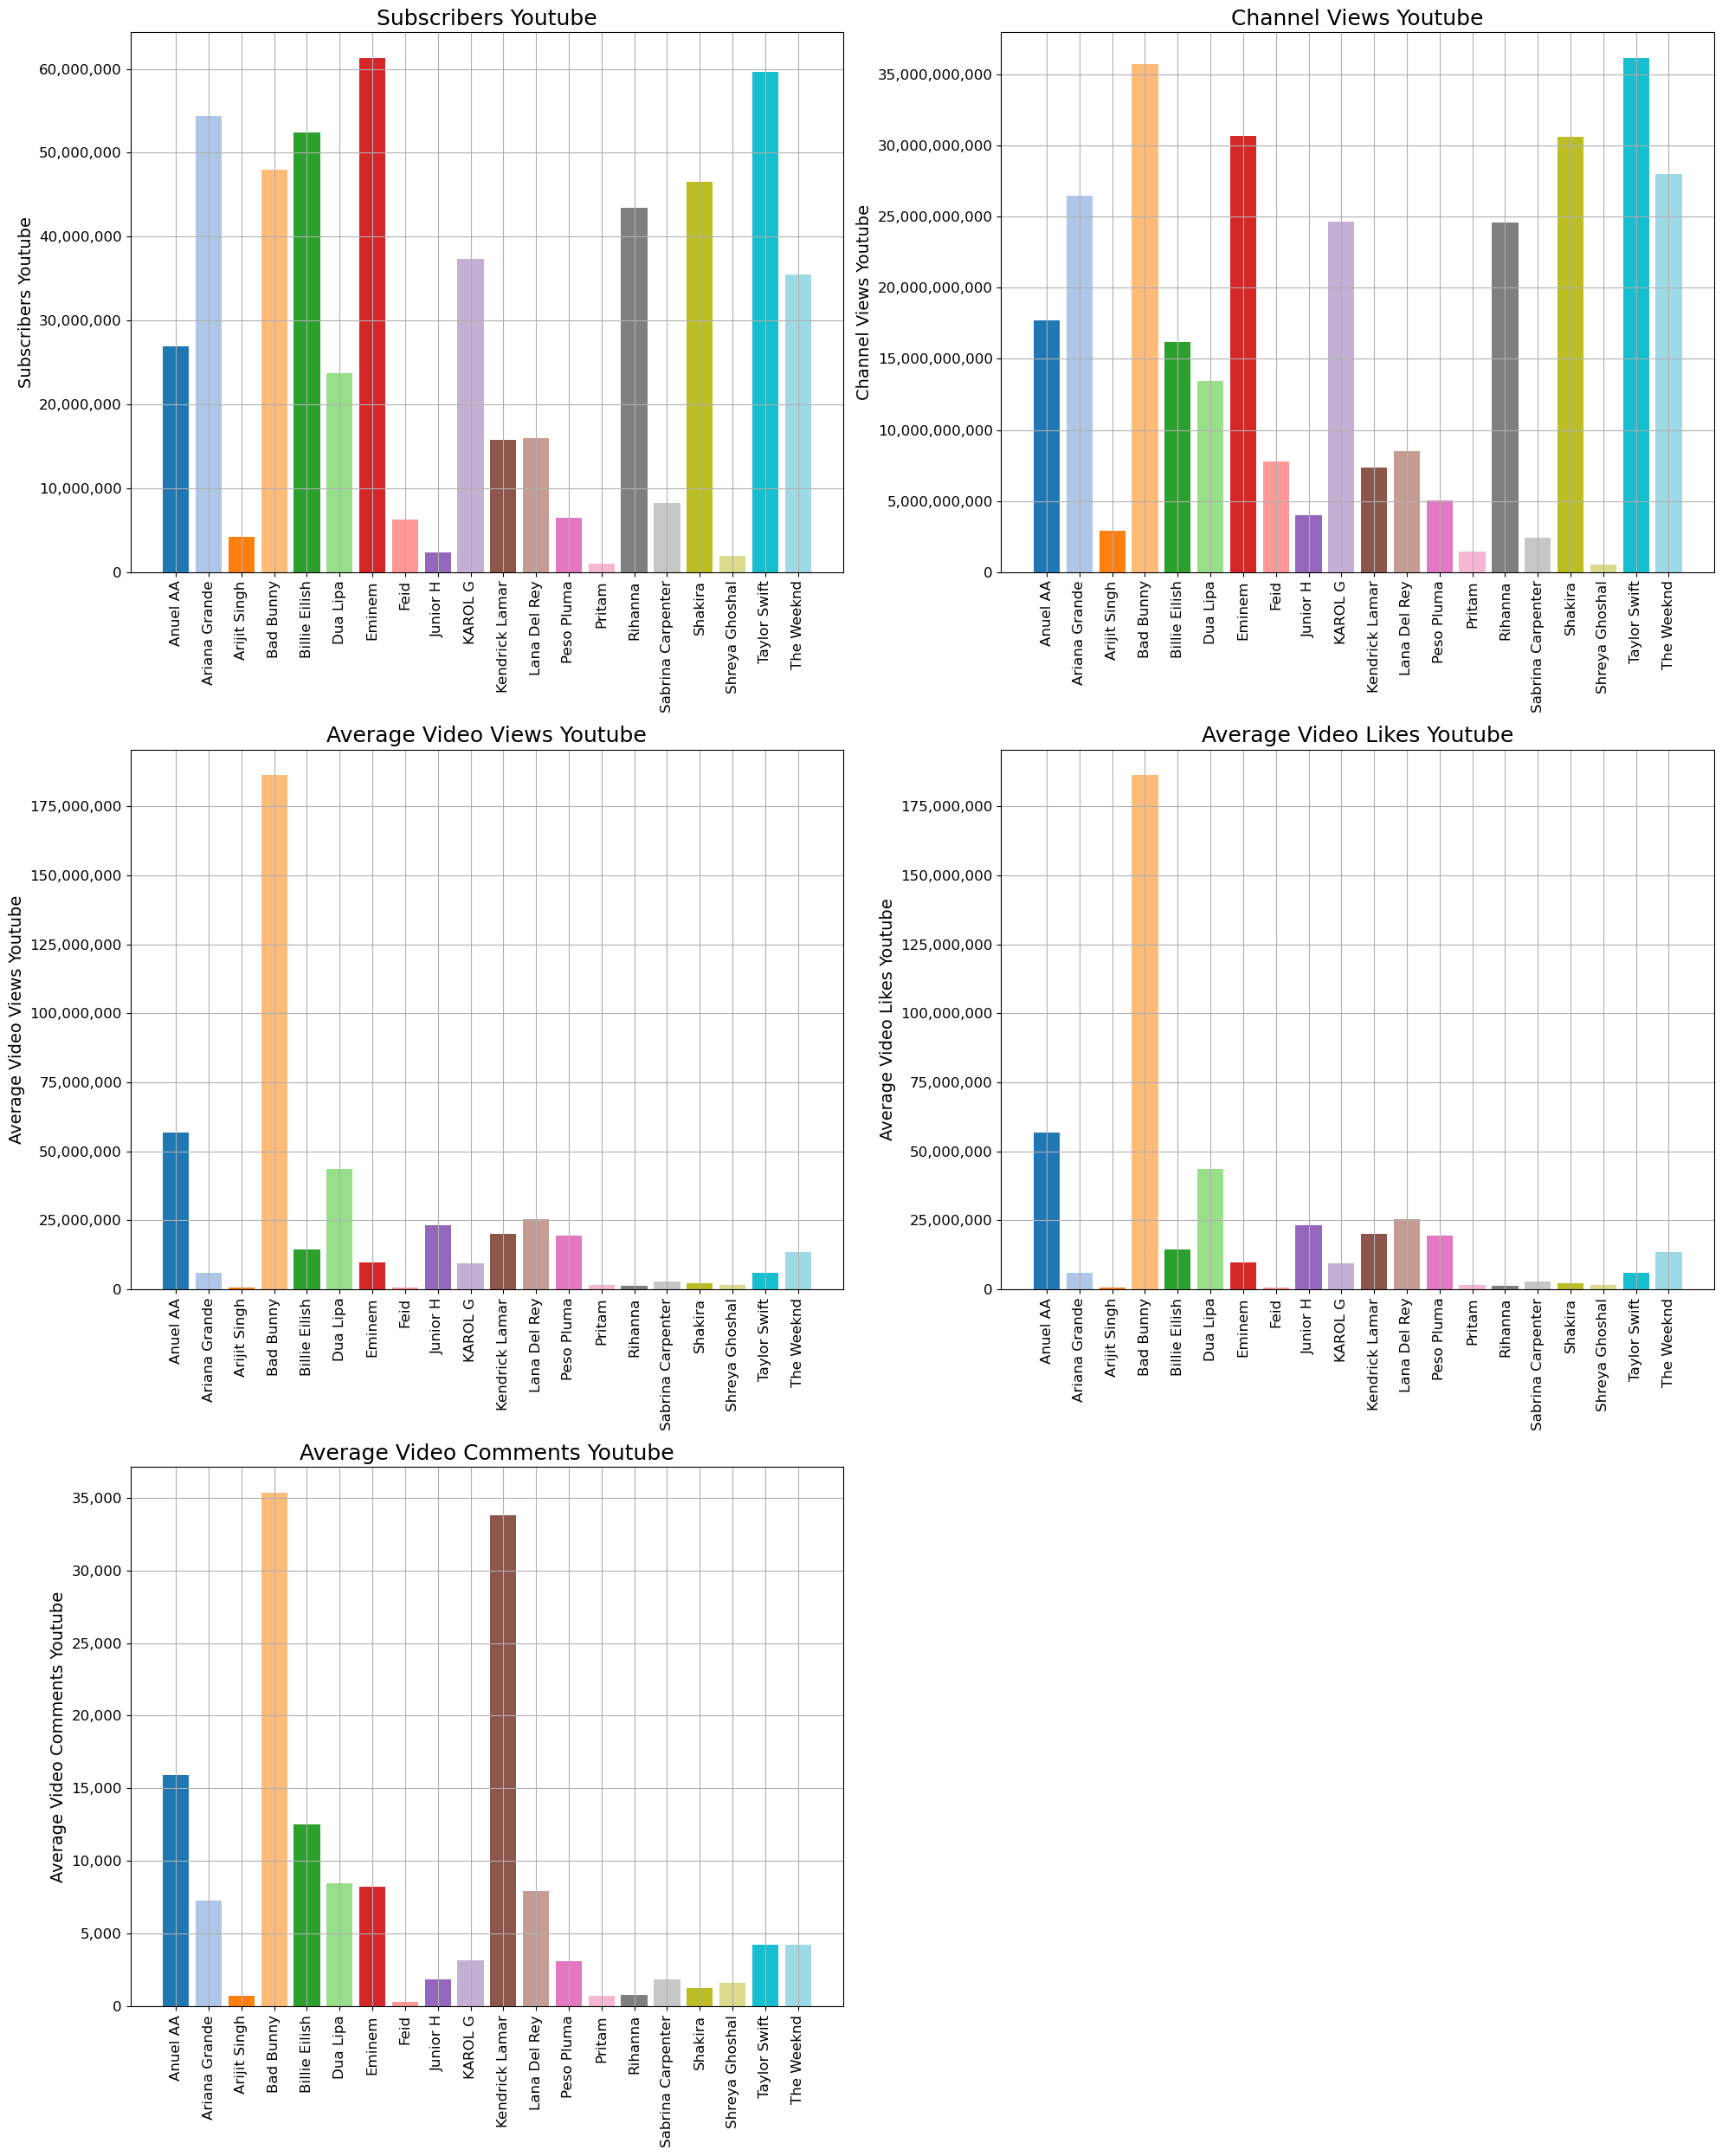

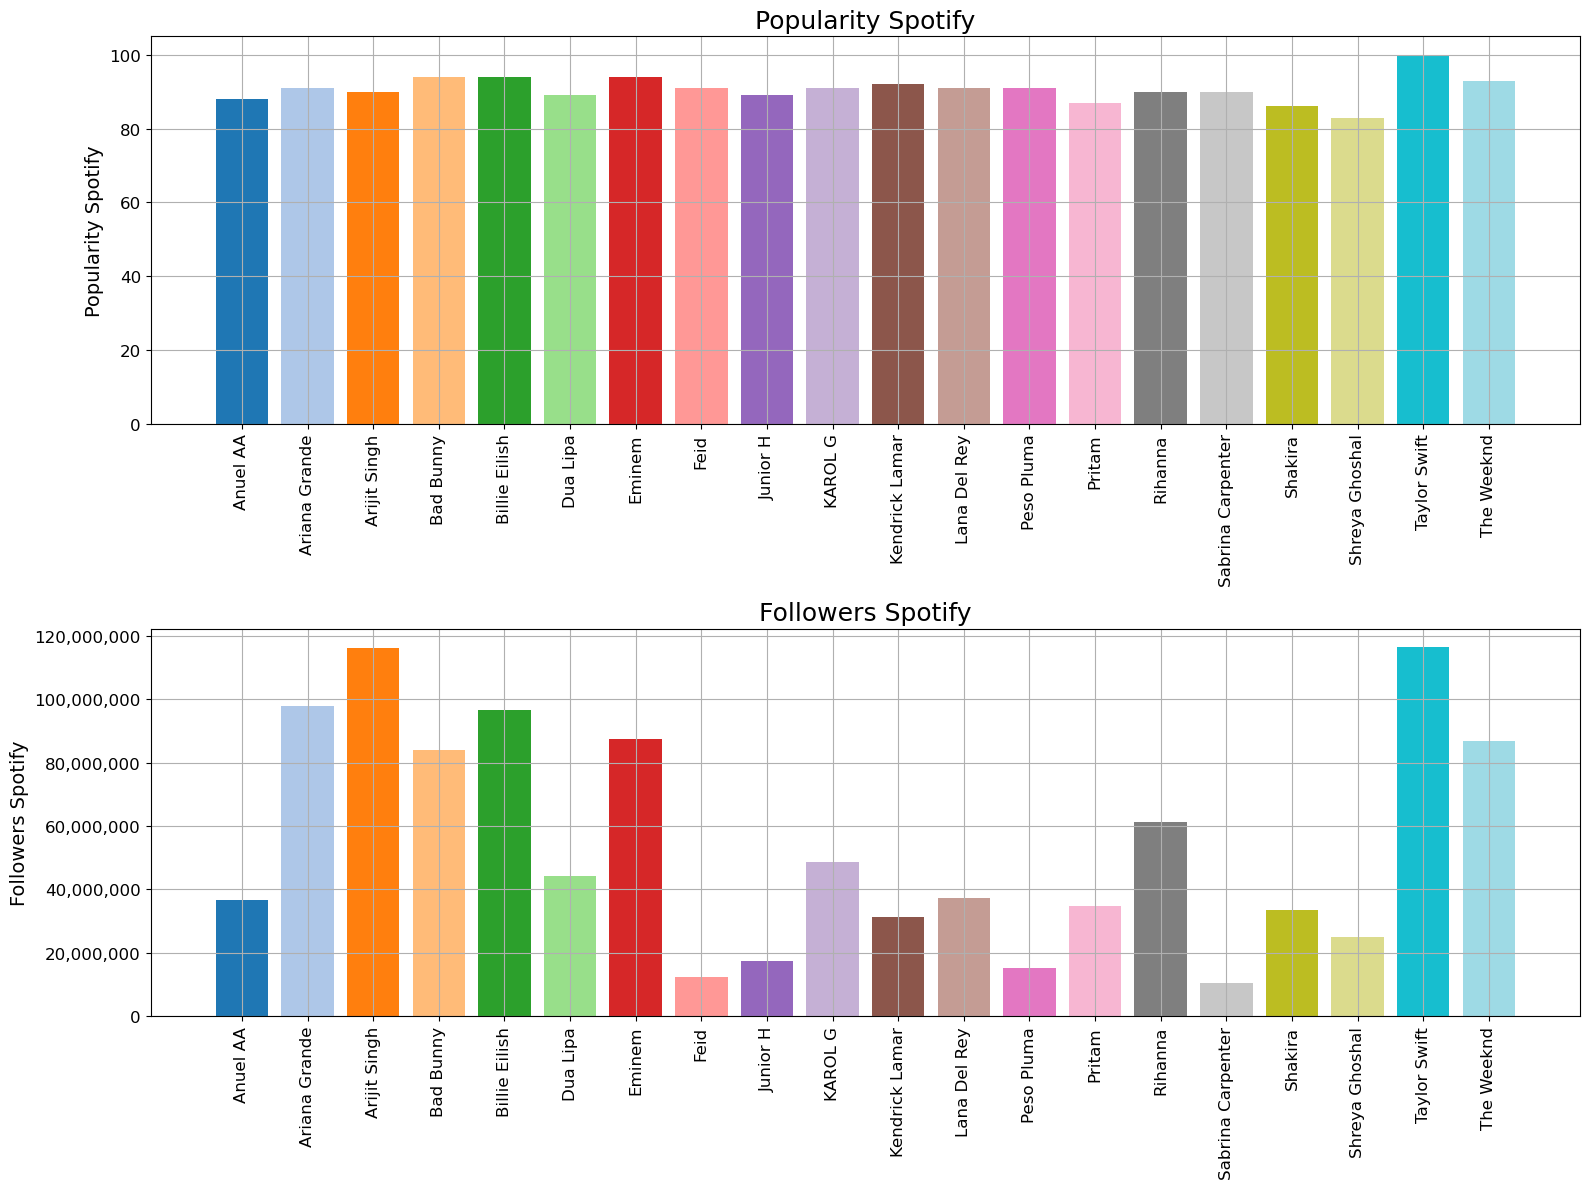

In [73]:
# Create bar plots for all metrics and all artists
# Define a color palette and dictionary
palette_1 = sns.color_palette("tab20", n_colors=len(popularity_metrics['Artist'].unique()))
artists = popularity_metrics['Artist'].unique()
color_dict = dict(zip(artists, palette_1))

# Increase the font sizes
title_fontsize = 18
label_fontsize = 14
tick_label_fontsize = 12

# Plot YouTube metrics
youtube_metrics = ['Subscribers_Youtube', 'Channel_Views_Youtube', 'Average_Video_Views_Youtube', 
                   'Average_Video_Likes_Youtube', 'Average_Video_Comments_Youtube']
fig, axes = plt.subplots(3, 2, figsize=(20, 25))

for i, metric in enumerate(youtube_metrics):
    ax = axes.flatten()[i]
    ax.bar(popularity_metrics['Artist'], popularity_metrics[metric], color=[color_dict[artist] for artist in popularity_metrics['Artist']])
    ax.set_title(f'{metric.replace("_", " ")}', fontsize=title_fontsize)
    ax.set_ylabel(f'{metric.replace("_", " ")}', fontsize=label_fontsize)
    ax.tick_params(axis='x', rotation=90, labelsize=tick_label_fontsize)
    ax.tick_params(axis='y', labelsize=tick_label_fontsize)
    ax.grid(True)
    # Format x-axis tick labels
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Hide the empty subplot
for j in range(i + 1, len(axes.flatten())):
    axes.flatten()[j].axis('off')
    
plt.tight_layout()
plt.savefig('visualizations/youtube_metrics_bar_chart.png')
plt.show()

# Plot Spotify metrics
spotify_metrics = ['Popularity_Spotify', 'Followers_Spotify']
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

for i, metric in enumerate(spotify_metrics):
    ax = axes.flatten()[i]
    ax.bar(popularity_metrics['Artist'], popularity_metrics[metric], color=[color_dict[artist] for artist in popularity_metrics['Artist']])
    ax.set_title(f'{metric.replace("_", " ")}', fontsize=title_fontsize)
    ax.set_ylabel(f'{metric.replace("_", " ")}', fontsize=label_fontsize)
    ax.tick_params(axis='x', rotation=90, labelsize=tick_label_fontsize)
    ax.tick_params(axis='y', labelsize=tick_label_fontsize)
    ax.grid(True)
    # Format y-axis tick labels
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.savefig('visualizations/spotify_metrics_bar_chart.png')
plt.show()

The bar plots of the different metrics show that the artists have quite different values for the popularity metrics of YouTube as well as Spotify. This could be due to some artists being not yet known for so long or belonging to a more specific genre.

YouTube:
- Subscribers on YouTube: In this plot we can see, that there is a quite large range of values of Subscribers on YouTube, with some Artists having a very high number of subscribers (f.ex. Eminem > 60 Mio) while other Artists have small numbers of subscribers (f.ex. Pritam & Junior H < 100,000). 
- Channel Views on YouTube: Similar to the Subscribers on YouTube there is also a quite large range of values of Channel Views on YouTube. Some Artists have very high numbers of Views (f.ex. Bad Bunny & Taylor Swift  > 35 Bio) and others have smaller numbers of Channel Views (f.ex. Shreya Ghoshal & Pritam < 5 Bio)  
&rarr; comparing the two plots we can see the tendency that artists with higher number of subscribers also have higher channel views and artists with lower numbers of subscribers have also lower channel views. 
- Average Views per Video on YouTube: We can see in the plot of the average views that the data is skewed and there are outliers. The most prominent visible outlier is Bad Bunny, having a very high number of average views per video (>175 Mio)
- Average Likes per Video on YouTube: Also in this plot we can see that the data is skewed and there are outliers. Again, the most prominent visible outlier is Bad Bunny, having a very high number of average likes per video (>175 Mio) 
- Average Comments per Video on YouTube: Again we can see  that the data is skewed and there are outliers. The two most prominent visible outliers are Bad Bunny and Kendrick Lamar both having a very high number of average comments below their videos (>30,000).  
&rarr; For this three metrics because of the outliers we can not see the differences between the other artists very well.  However, a general trend is that artists with higher average views per video also tend to receive more likes and comments, and vice versa.

Spotify:
- Popularity on Spotify: The Spotify popularity metric shows less variability compared to the YouTube metrics, with values ranging between 80 and 100. This narrow range is due to the metric being scaled from 0 to 100. All of the artists reach a popularity score above 80.
- Followers on Spotify: In this plot we can see, that also here there is a quite large range of values of Followers on Spotify, with some Artists having a very high number of followers (f.ex. Taylor Swift and Arijit Singh > 120 Mio) while other Artists have smaller numbers of followers (f.ex. Feid & Sabrina Carpenter < 20 Mio). Comparing it to the number of Subscribers on YouTube we can see that the ranges differ. While on YouTube the highest number of Subscribers is around 60 Mio, on Spotify the highest number of Followers is around 120 Mio (twice as high). Also we can see that Artists that have large numbers of subscribers on YouTube do not necessarily have large numbers of Followers on Spotify and vice versa (f.ex. Arijit Singh).

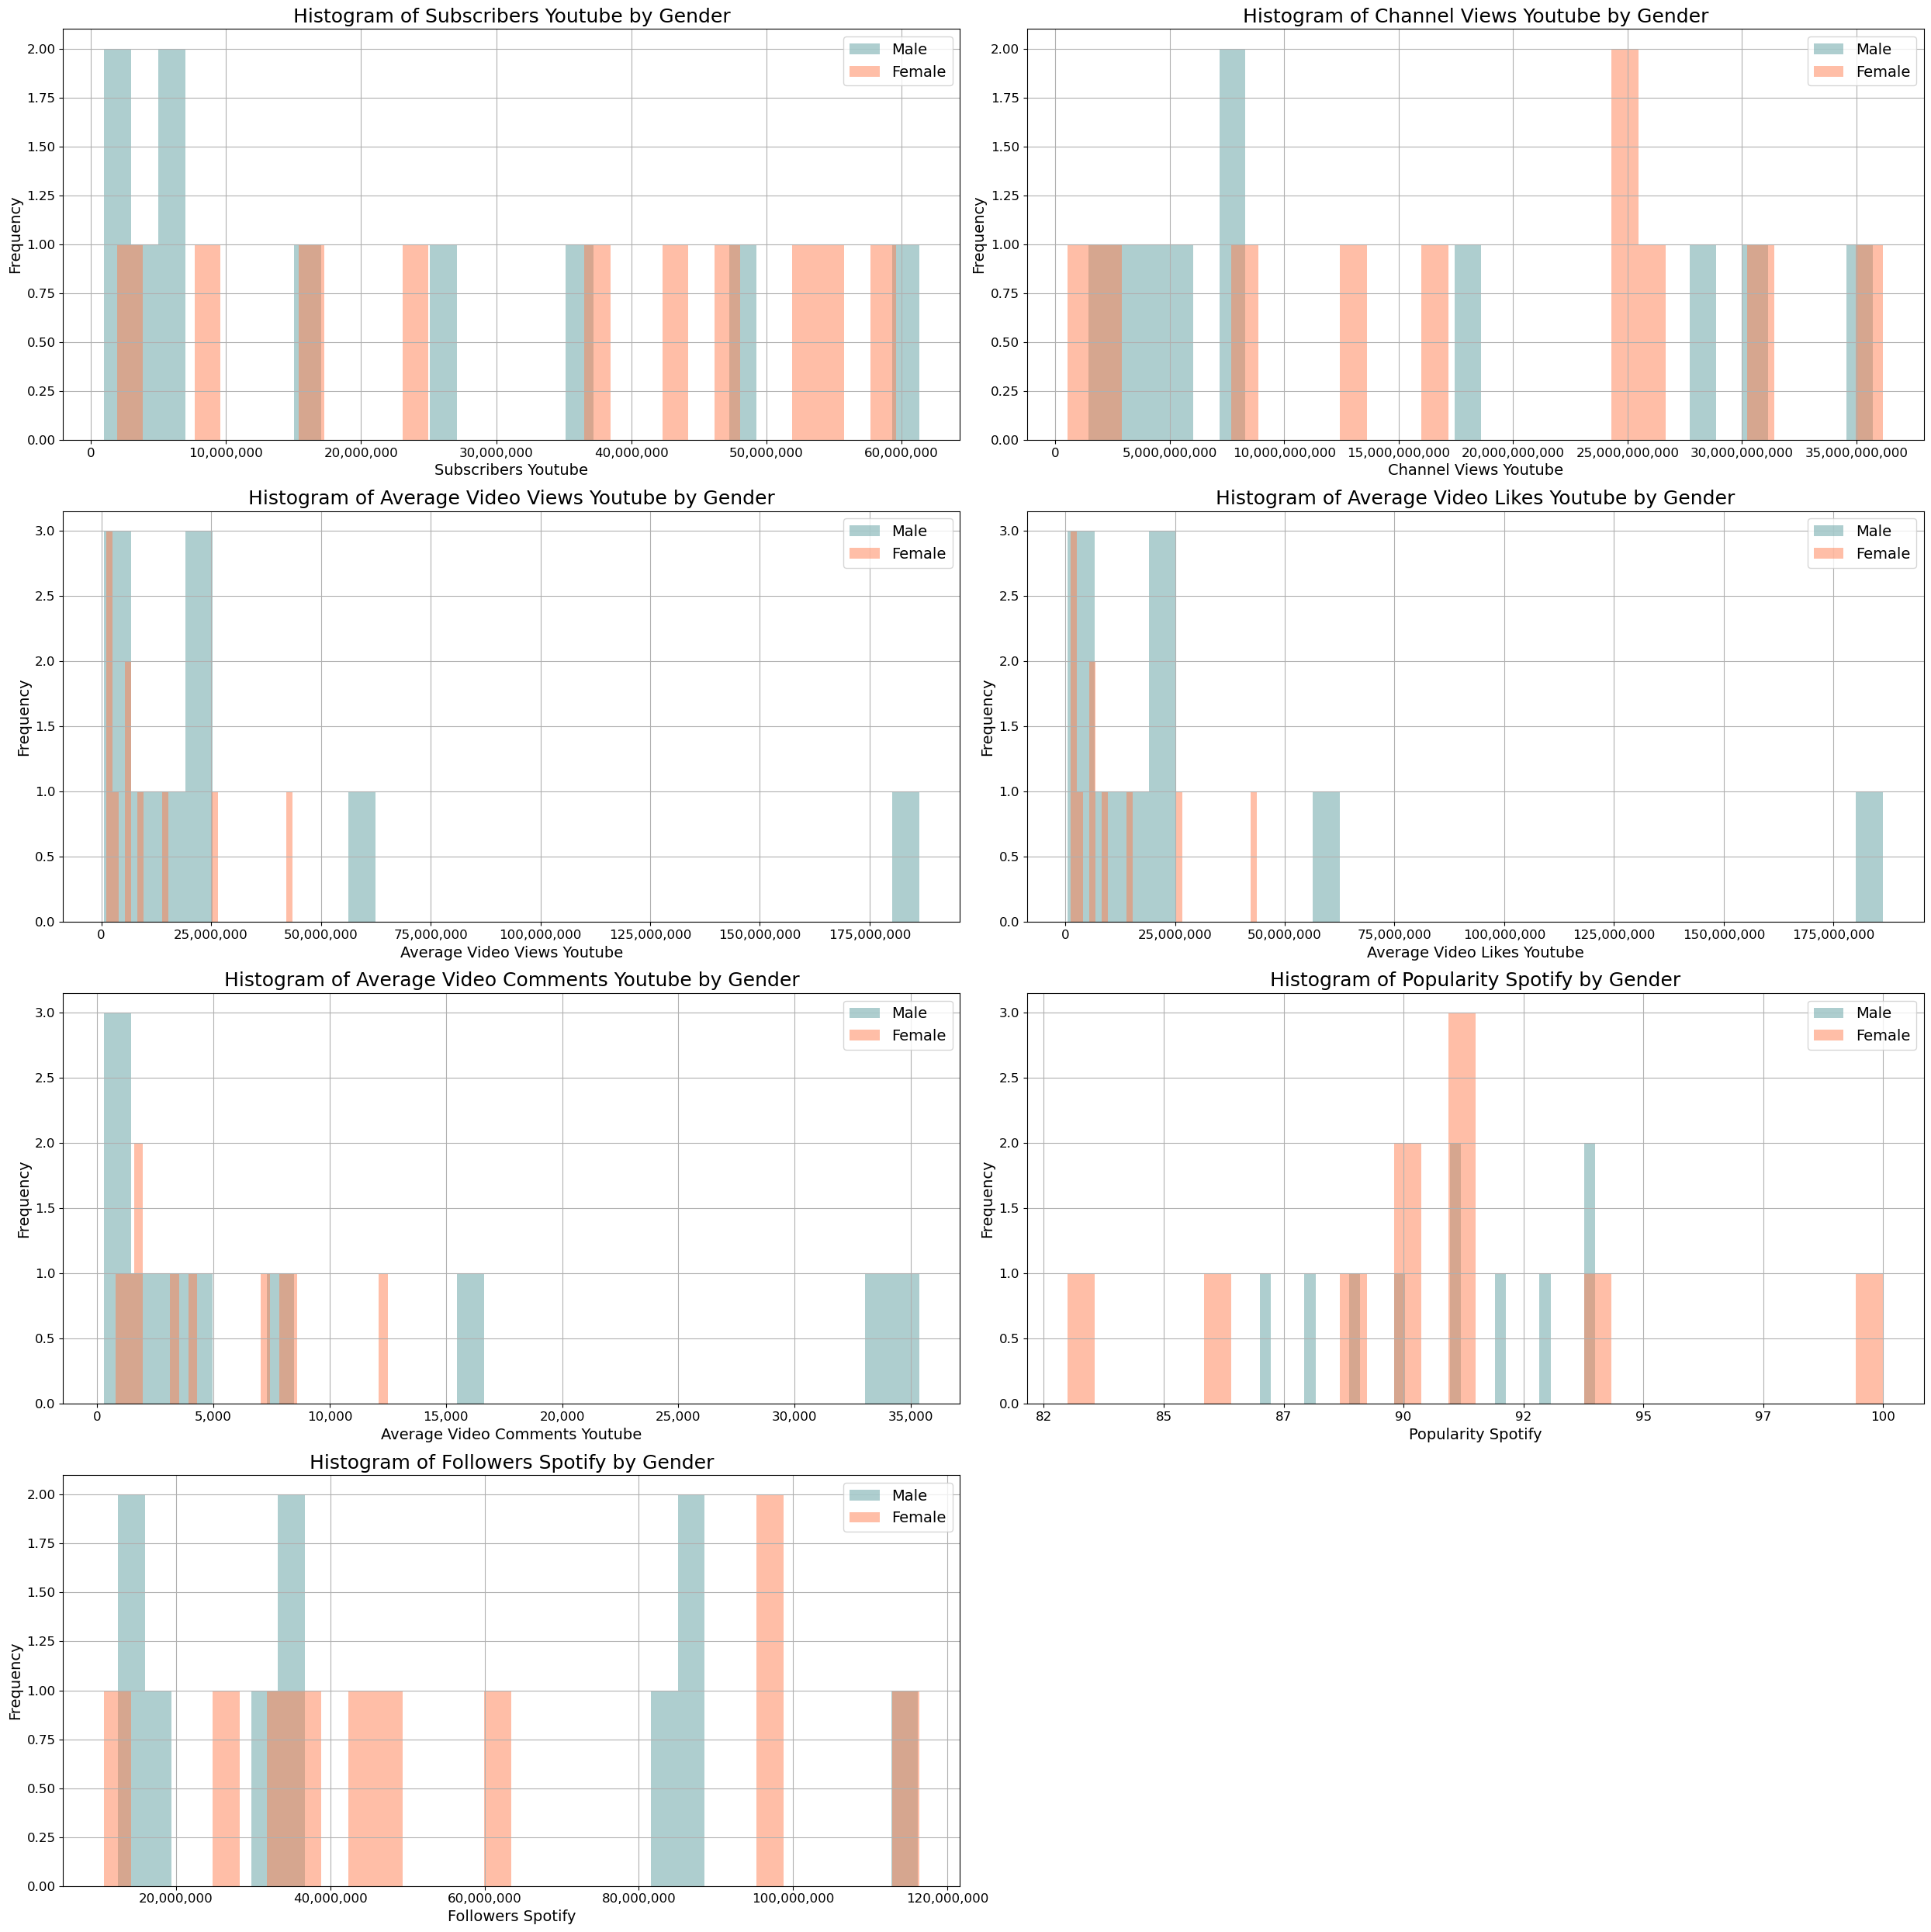

In [74]:
# Define the metrics to plot
metrics_to_plot = ['Subscribers_Youtube', 'Channel_Views_Youtube', 'Average_Video_Views_Youtube', 
                   'Average_Video_Likes_Youtube', 'Average_Video_Comments_Youtube', 
                   'Popularity_Spotify', 'Followers_Spotify']

# Define a color palette for gender
palette_2 = {'male': 'cadetblue', 'female': 'coral'}

# Plot the histograms of the metrics by gender
# Determine the layout of the subplots
n_metrics = len(metrics_to_plot)
n_cols = 2
n_rows = (n_metrics + 1) // n_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 25))

for i, metric in enumerate(metrics_to_plot):
    male_data = popularity_metrics[popularity_metrics['Gender'] == 'male'][metric]
    female_data = popularity_metrics[popularity_metrics['Gender'] == 'female'][metric]
    
    ax = axes.flatten()[i]
    ax.hist(male_data, bins=30, alpha=0.5, label='Male', color=palette_2['male'])
    ax.hist(female_data, bins=30, alpha=0.5, label='Female', color=palette_2['female'])
    ax.set_title(f'Histogram of {metric.replace("_", " ")} by Gender', fontsize=title_fontsize)
    ax.set_ylabel('Frequency', fontsize=label_fontsize)
    ax.set_xlabel(f'{metric.replace("_", " ")}', fontsize=label_fontsize)
    ax.tick_params(axis='x', labelsize=tick_label_fontsize)
    ax.tick_params(axis='y', labelsize=tick_label_fontsize)
    ax.legend(fontsize=label_fontsize)
    ax.grid(True)
    # Format x-axis tick labels
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Hide any unused subplots
for j in range(i + 1, len(axes.flatten())):
    axes.flatten()[j].axis('off')


plt.tight_layout()
plt.savefig('visualizations/histogram_metrics.png')
plt.show()

YouTube:
- Subscribers: Both male and female artists appear in different subscriber ranges (up to 70 Mio), it appears that both genders have a relatively similar distribution across these ranges. However, a few more male artists seem to appear at the lower value ranges of subscribers.
- Channel Views: Also here both male and female artists appear in different channel view ranges (up to 35 Bio). It appears that both genders have a relatively similar distribution across these ranges. However, also here a few more male artists seem to appear at the lower value ranges of subscribers.
- Average views per video: Here we can see that the distribution of the data is quite skewed because of three outliers. Two outliers in the male data having a large number of average views per video and one outlier in the female data that has a larger number of average views per video but not has high as the male outliers. For both genders the values are concentrated between 0 and 25 Mio. The female data tends to have slightely more values in the lower range than male data. 
- Average likes per video: Also here, we can see that the distribution of the data is quite skewed because of three outliers. Two outliers in the male data having a large number of average views per video and one outlier in the female data that has a larger number of average views per video but not has high as the male outliers. For both genders the values are concentrated between 0 and 25 Mio. The female data tends to have slightely more values in the lower range than male data. 
- Average comments per video: Also in this plot we can see that the data is quite skewed. We can see two extreme outliers in the male data with values above 30,000. Most values for the both genders are concentrated at the values below 10,000.

Spotify:
- Popularity: In this histogram we can see that both male and female artists show a strong presence in the higher popularity ranges. The female data shows a slightly higher value range with values ranging from 83 to 100. The male data shows a slightly narrower value range with most values between 87 and 95.
- Followers: Both male and female artists appear in different follower ranges (up to 120 Mio), it appears that both genders have a relatively similar distribution across these ranges. However, a few more male artists seem to appear at the lower value ranges of subscribers.


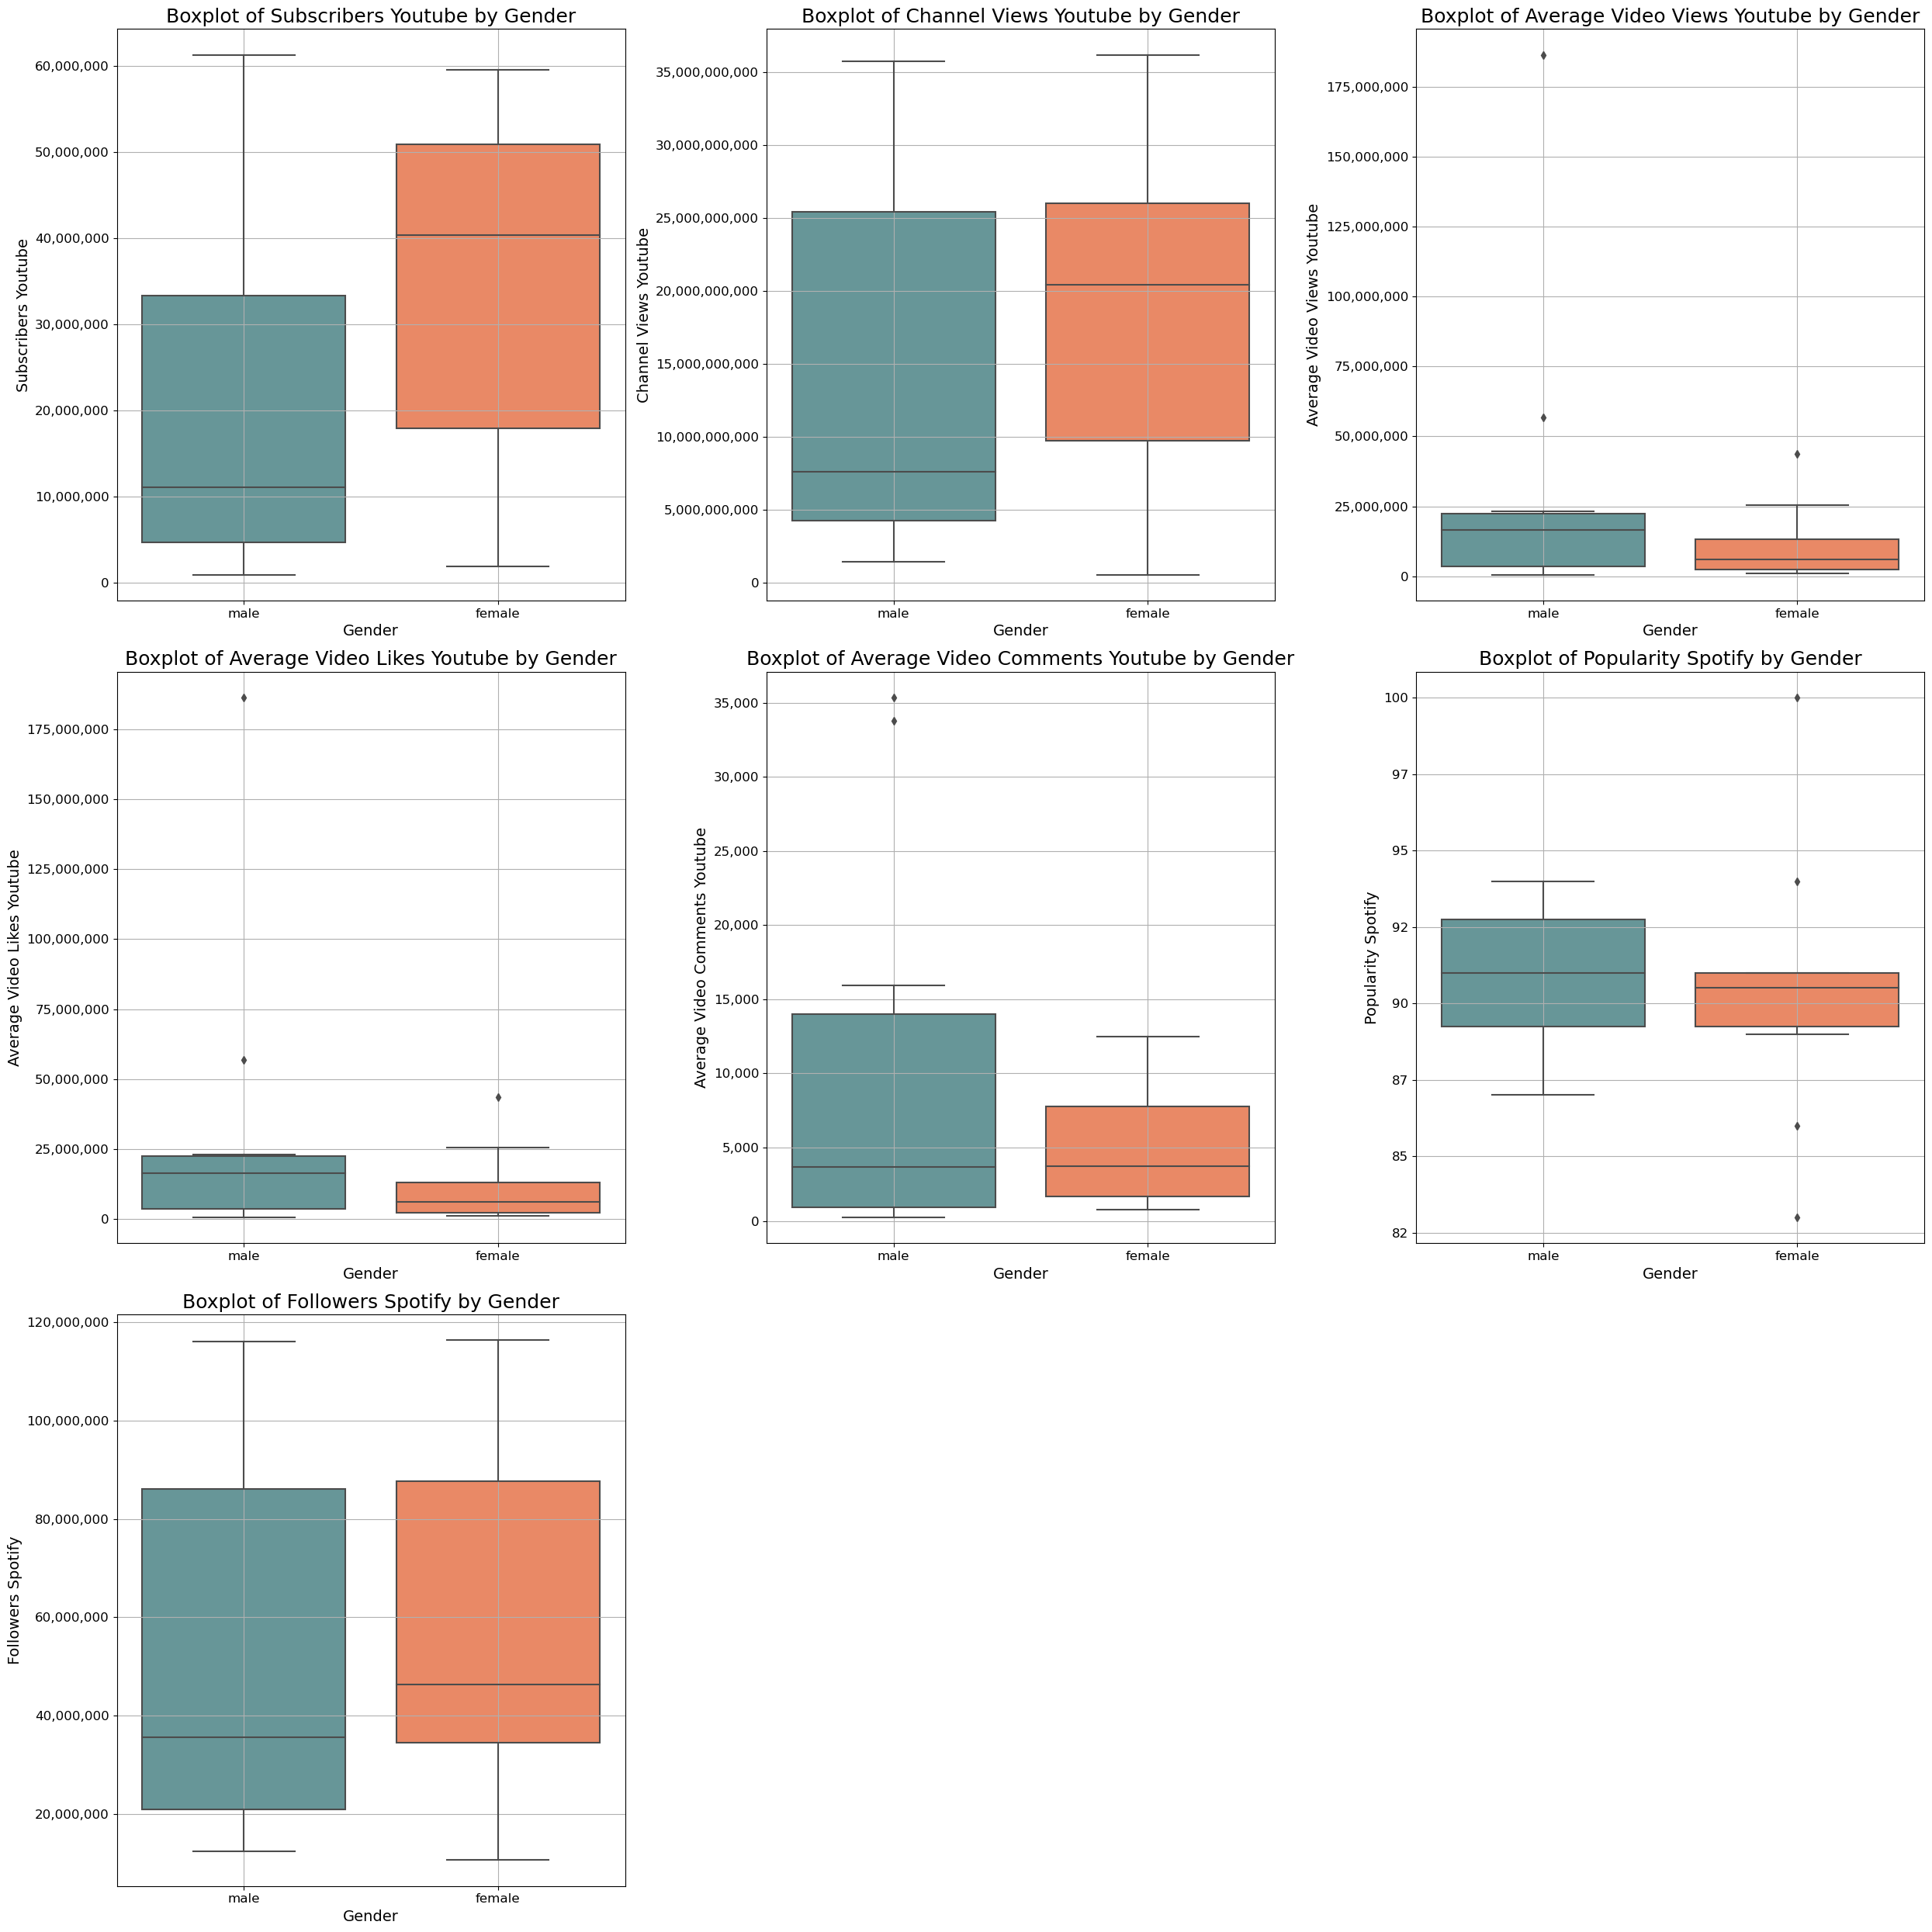

In [76]:
# Plot boxplots of the metrics
# Determine the number of rows and columns for the grid
num_metrics = len(metrics_to_plot)
num_columns = 3  # Number of columns in the grid
num_rows = (num_metrics + num_columns - 1) // num_columns  # Calculate the number of rows

# Set up the figure with the grid of subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 25))

# Create a boxplot for each metric
for i, metric in enumerate(metrics_to_plot):
    ax = axes.flatten()[i]  
    sns.boxplot(x='Gender', y=metric, data=popularity_metrics, ax=ax, palette=palette_2)
    ax.set_title(f'Boxplot of {metric.replace("_", " ")} by Gender', fontsize=title_fontsize)
    ax.set_ylabel(f'{metric.replace("_", " ")}', fontsize=label_fontsize)
    ax.set_xlabel('Gender', fontsize=label_fontsize)
    ax.tick_params(axis='x', labelsize=tick_label_fontsize)
    ax.tick_params(axis='y', labelsize=tick_label_fontsize)
    ax.grid(True)
    # Format y-axis tick labels
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Remove any unused subplots
for j in range(i + 1, len(axes.flatten())):
    axes.flatten()[j].axis('off')

plt.tight_layout()
plt.savefig('visualizations/boxplot_metrics.png')
plt.show()

YouTube:

- Subscribers: The boxplot shows that female artists have a higher median and a wider interquartile range compared to male artists. This suggests that there is a  greater variability in numer of subscribers among female artists and that they tend to have a higher number of subscribers. The distribution of the female data is left-skewed, while the distribution of the male data is right-skewed.
- Channel Views: The median channel views for female artists are higher suggesting they have higher channel views than male artists. Male artists show a wider interquartile range, suggesting a greater variability in channel views among male artists. The distribution of the female data is left-skewed, while the distribution of the male data is right-skewed.
- Average Views per Video: The distribution of average views per video is skewed for both genders. The male artists’ boxplot shows two significant outliers — one with average views >175 million and one with average views >50 million. For female artists, there is one notable outlier. The male median exceeds the female median, also the interquartile range of male artists is wider than the interquartile range of female artists. This suggests that male artists tend to have a higher number of average views per vide and that there is more variability in the average views per video among male artists compared to female artists. The distribution of the male data is left-skewed, while the distribution of the female data is right-skewed.
- Average Likes per Video: The boxplot for average likes per video also shows skewness. There are two outliers among male artists — one with average views >175 million and one with average views >50 million. Female artists have one outlier. The male median is higher than the female median, the interquartile range of male artists seems wider than the interquartile range of female artists. This suggests that male artists tend to have a higher number of average views per vide and that there is more variability in the average likes per video among male artists compared to female artists. The distribution of the male data is left-skewed, while the distribution of the female data is right-skewed.
- Average Comments per Video: The median number of comments per video is approximately the same for both male and female artists. However, The interquartile range of male artists is wider than the interquartile range of female artists suggesting more variability in average comments per video .The male boxplot includes two outliers with more than 30,000 comments per video. The distribution of the data of both genders is right-skewed.

Spotify:

- Popularity: The median popularity score is similar for both male and female artists. The boxplot for female artists shows four outliers — two with a popularity above 92 and two below 87. The range of popularity scores is narrow for both genders, with female artists showing a smaller interquartile range than male artists. While the distribution of the male data is approximately normally distributed, the distribution of the female data is left-skewed.
- Followers: The boxplots indicate that the median number of followers is higher for female artists than for male artists.  Male artists show a wider interquartile range, suggesting a greater variability in the number of folllowers among male artists. The distribution of the data of both genders is right-skewed. 

In [77]:
# Log transformation of Average Video Views, Average Likes and Average Comments (because of outliers, skewed data)
popularity_metrics['Log_Average_Video_Views'] = np.log(popularity_metrics['Average_Video_Views_Youtube'])
popularity_metrics['Log_Average_Video_Likes'] = np.log(popularity_metrics['Average_Video_Likes_Youtube'])
popularity_metrics['Log_Average_Video_Comments'] = np.log(popularity_metrics['Average_Video_Comments_Youtube'])

# Aggregate metrics by gender
metrics_by_gender = popularity_metrics.groupby('Gender').agg({
    'Subscribers_Youtube': ['sum', 'mean'],          # Total and average subscribers
    'Channel_Views_Youtube': ['sum', 'mean'],        # Total and average channel views
    'Log_Average_Video_Views': 'mean',               # Mean log-transformed views
    'Log_Average_Video_Likes': 'mean',               # Mean log-transformed likes
    'Log_Average_Video_Comments': 'mean',            # Mean log-transformed comments
    'Popularity_Spotify': 'mean',                    # Mean Spotify popularity score
    'Followers_Spotify': ['sum', 'mean']             # Total and average followers on Spotify
}).reset_index()

# Rename columns for clarity
metrics_by_gender.columns = [
    'Gender',
    'Total_Subscribers_Youtube',
    'Average_Subscribers_Youtube',
    'Total_Channel_Views_Youtube',
    'Average_Channel_Views_Youtube',
    'Log_Average_Video_Views',
    'Log_Average_Video_Likes',
    'Log_Average_Video_Comments',
    'Average_Popularity_Spotify',
    'Total_Followers_Spotify',
    'Average_Followers_Spotify'
]

# Save to csv
metrics_by_gender.to_csv('popularity_metrics/metrics_by_gender.csv', index = False)
metrics_by_gender

,Gender,Total_Subscribers_Youtube,Average_Subscribers_Youtube,Total_Channel_Views_Youtube,Average_Channel_Views_Youtube,Log_Average_Video_Views,Log_Average_Video_Likes,Log_Average_Video_Comments,Average_Popularity_Spotify,Total_Followers_Spotify,Average_Followers_Spotify
0,female,343490000,34349000.0,183600465230,1.836005e+10,15.594014,15.594014,8.152259,90.5,571336449,57133644.9
1,male,207719000,20771900.0,140560099320,1.405601e+10,16.081092,16.081092,8.230162,90.9,521659301,52165930.1


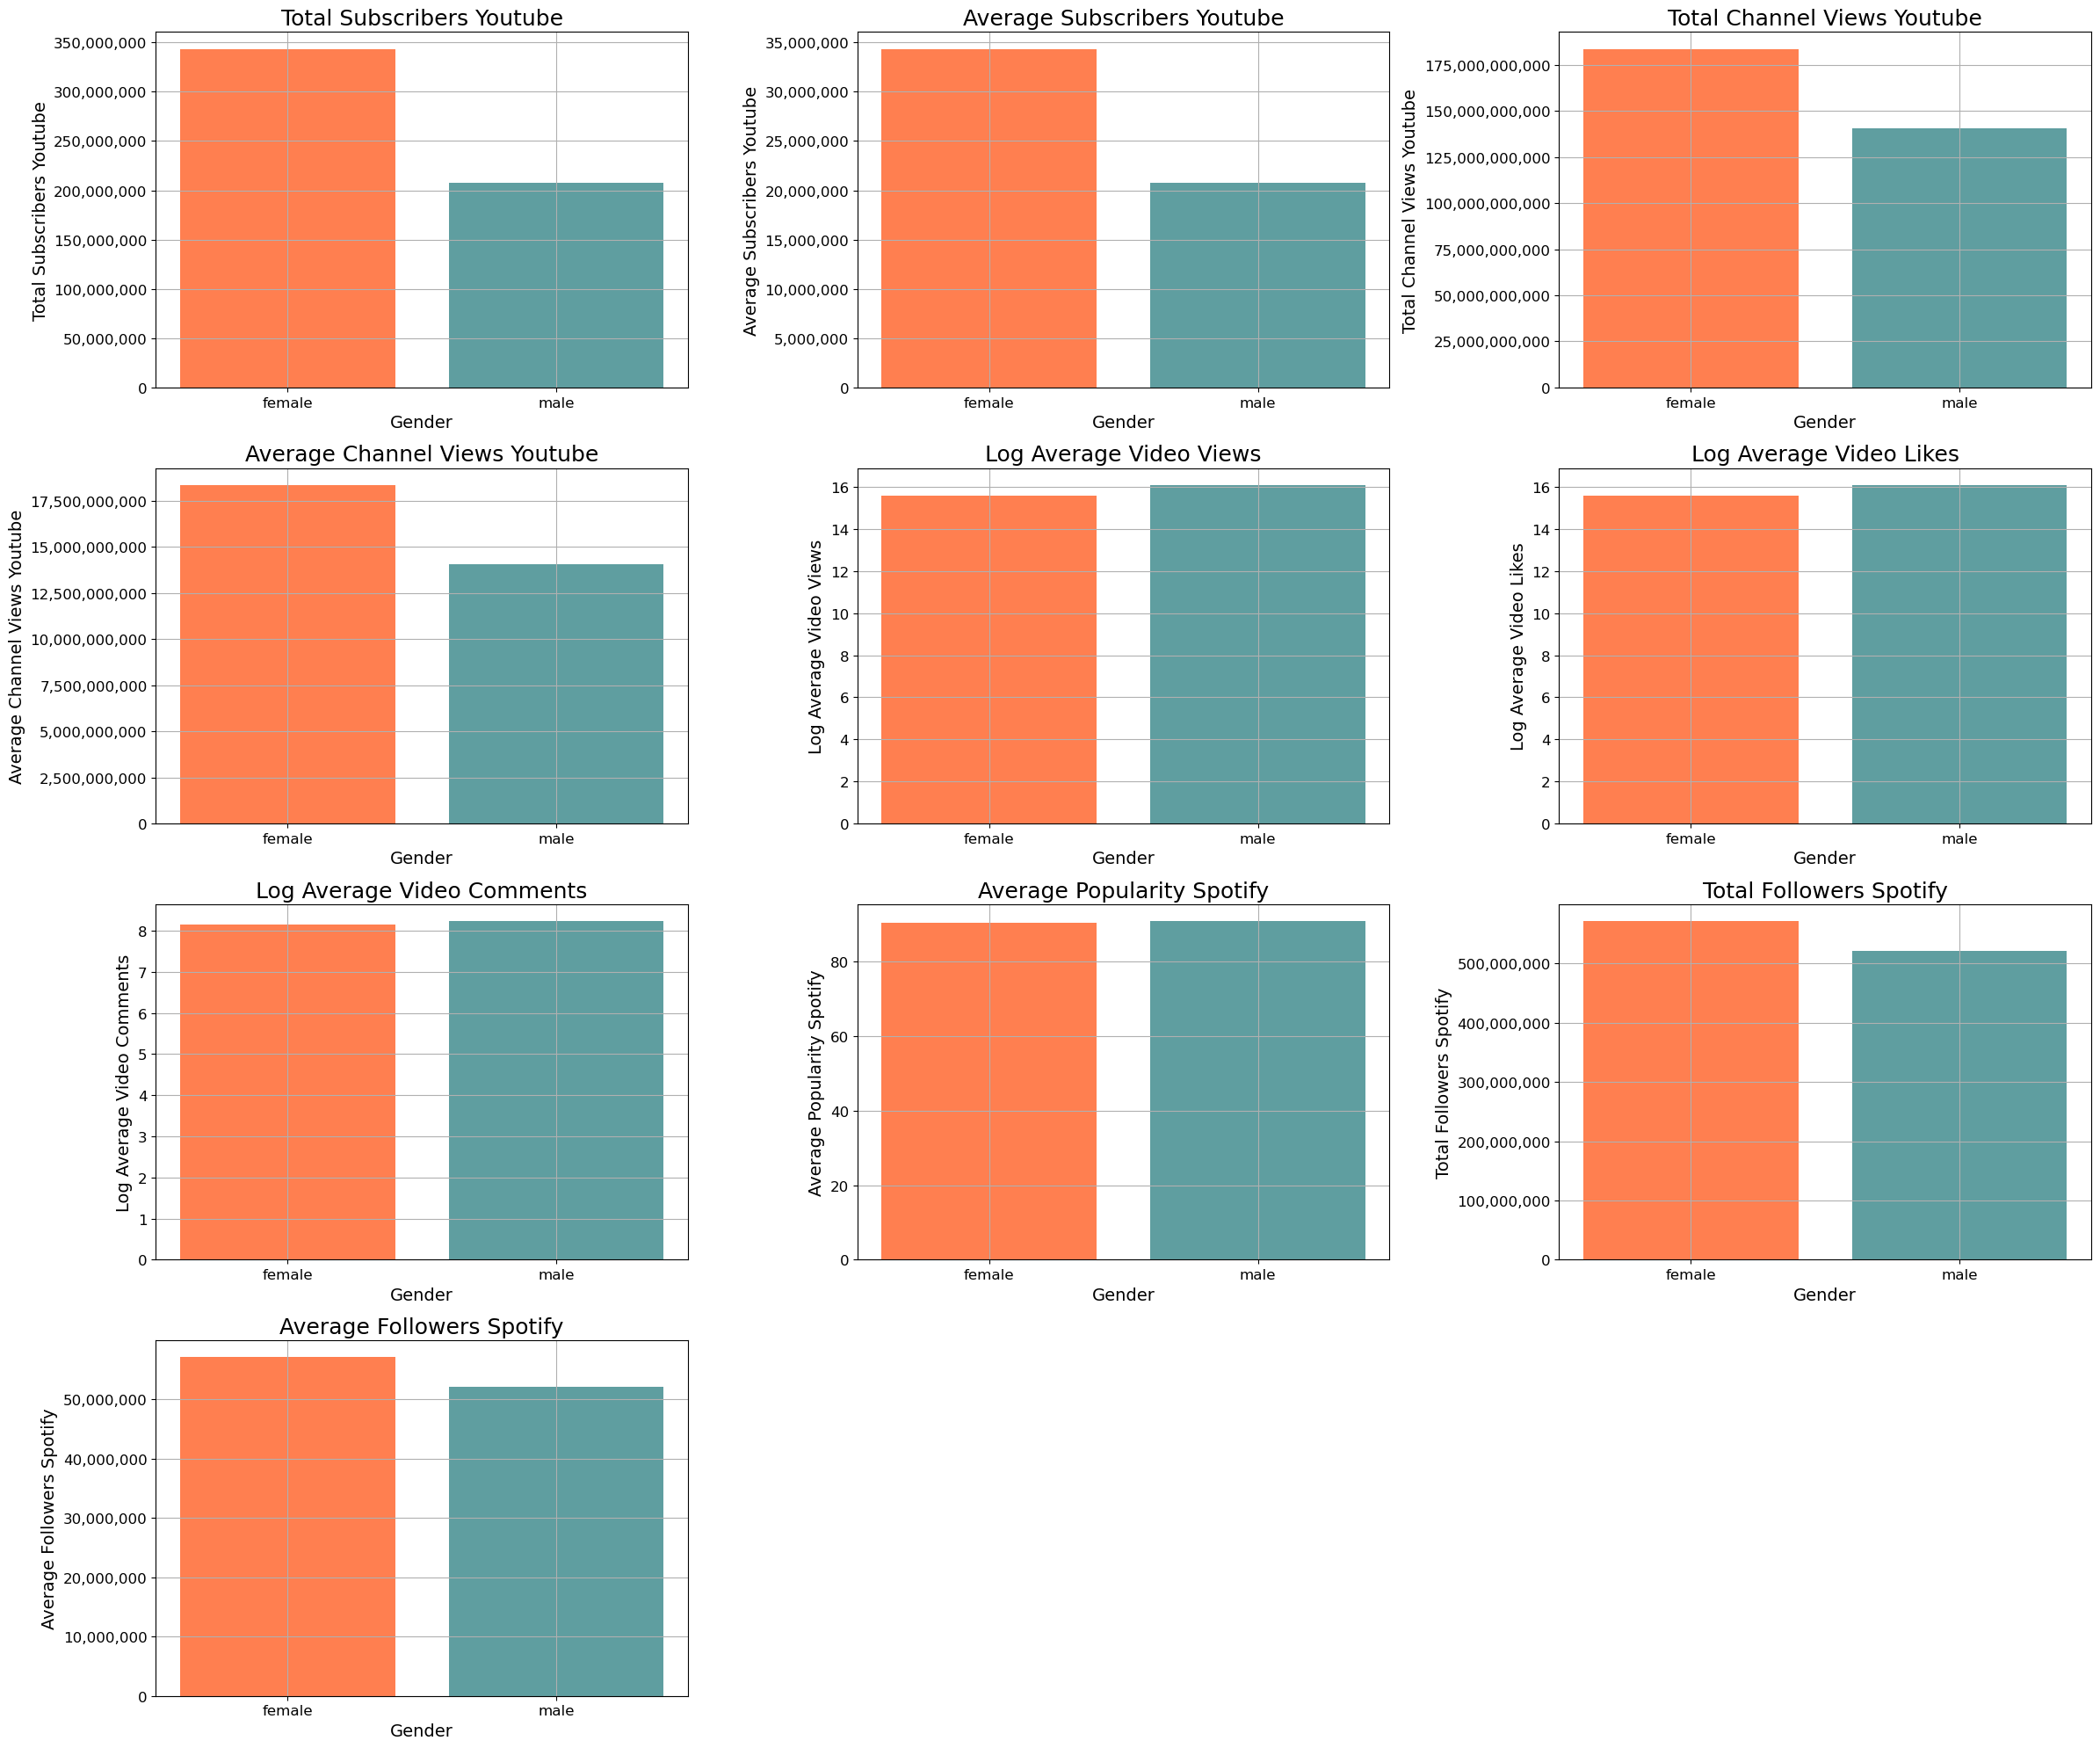

In [78]:
# Select the Aggregated metrics to plot
aggregated_metrics = ['Total_Subscribers_Youtube', 'Average_Subscribers_Youtube', 'Total_Channel_Views_Youtube', 
                      'Average_Channel_Views_Youtube', 'Log_Average_Video_Views', 'Log_Average_Video_Likes',
                      'Log_Average_Video_Comments', 'Average_Popularity_Spotify', 'Total_Followers_Spotify', 
                      'Average_Followers_Spotify']

# Adjust the number of rows and columns based on the number of metrics
num_metrics = len(aggregated_metrics)
num_columns = 3  # Number of columns
num_rows = (num_metrics + num_columns - 1) // num_columns  # Calculate the number of rows needed

# Create the subplot grid
fig, axes = plt.subplots(num_rows, num_columns, figsize=(24, 5 * num_rows))

# Loop through aggregated metrics and create bar plots
for i, metric in enumerate(aggregated_metrics):
    ax = axes.flatten()[i]
    colors = metrics_per_gender['Gender'].map(palette)
    ax.bar(metrics_per_gender['Gender'], metrics_per_gender[metric], color=colors)
    ax.set_title(f'{metric.replace("_", " ")}', fontsize=title_fontsize)
    ax.set_ylabel(f'{metric.replace("_", " ")}', fontsize=label_fontsize)
    ax.set_xlabel('Gender', fontsize=label_fontsize)
    ax.tick_params(axis='x', labelsize=tick_label_fontsize)
    ax.tick_params(axis='y', labelsize=tick_label_fontsize)
    ax.grid(True)
    # Format y-axis tick labels
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))


# Hide any unused subplots
for j in range(i + 1, len(axes.flatten())):
    axes.flatten()[j].axis('off')

plt.tight_layout()
plt.savefig('visualizations/aggregated_metrics_bar_chart.png') 
plt.show()

YouTube:

- Total / Average Subscribers: Both plots show that female artists have a higher total and average number of subscribers compared to male artists. This means female artists tend to have more subscribers than male artists, suggesting female artists have a larger cumulative audience.
- Total / Average Channel Views: Both plots show that female artists have a higher total and average number of channel views compared to male artists. Female artists appear to generate more channel views, indicating potentially more popular or widely viewed content.
- Log Average Views per Video: Female and male artists have similar values for the logarithm of average video views. We can see that male artists have slightely higher views on average. However we can see, when normalized on a logarithmic scale, the average views per video between the genders are almost equal, indicating similar engagement per video.
- Log Average Likes per Video: Similar to the logarithm of average views per video, the logarithm of average likes per video are nearly equal between male and female artists. Male artists have slightely higher likes. So after accounting for the outliers we can see that the videos from both genders receive similar number of likes on average. 
- Log Average Comments per Video: In this plot we can see that the logarithmic average of video comments is nearly the same for male and female artists. So this suggests that female and male artists tend to receive same numbers of comments below their videos.


Spotify:

- Average Popularity: In this plot we can see that the average popularity on Spotify seems to be similar for both genders.
- Total / Average Followers: Both plots show that female artists have a higher total and average number of subscribers compared to male artists. This means female artists tend to have more subscribers than male artists. However the difference between male and female artists in the number of followers on Spotify seems to be smaller than the difference in the number of subscribers on YouTube.

**Step 4: Perform Statistical Tests to Answer Research Question 1**

In [29]:
# Select the metrics that should be used for statistical tests
metrics_tests = ['Subscribers_Youtube', 'Channel_Views_Youtube','Log_Average_Video_Views',
                 'Log_Average_Video_Likes', 'Log_Average_Video_Comments', 'Popularity_Spotify','Followers_Spotify']

                            Subscribers_Youtube  Channel_Views_Youtube  \
Subscribers_Youtube                    1.000000               0.926125   
Channel_Views_Youtube                  0.926125               1.000000   
Log_Average_Video_Views                0.256901               0.293478   
Log_Average_Video_Likes                0.256901               0.293478   
Log_Average_Video_Comments             0.434055               0.362139   
Popularity_Spotify                     0.578227               0.546139   
Followers_Spotify                      0.667642               0.592569   

                            Log_Average_Video_Views  Log_Average_Video_Likes  \
Subscribers_Youtube                        0.256901                 0.256901   
Channel_Views_Youtube                      0.293478                 0.293478   
Log_Average_Video_Views                    1.000000                 1.000000   
Log_Average_Video_Likes                    1.000000                 1.000000   
Log_Ave

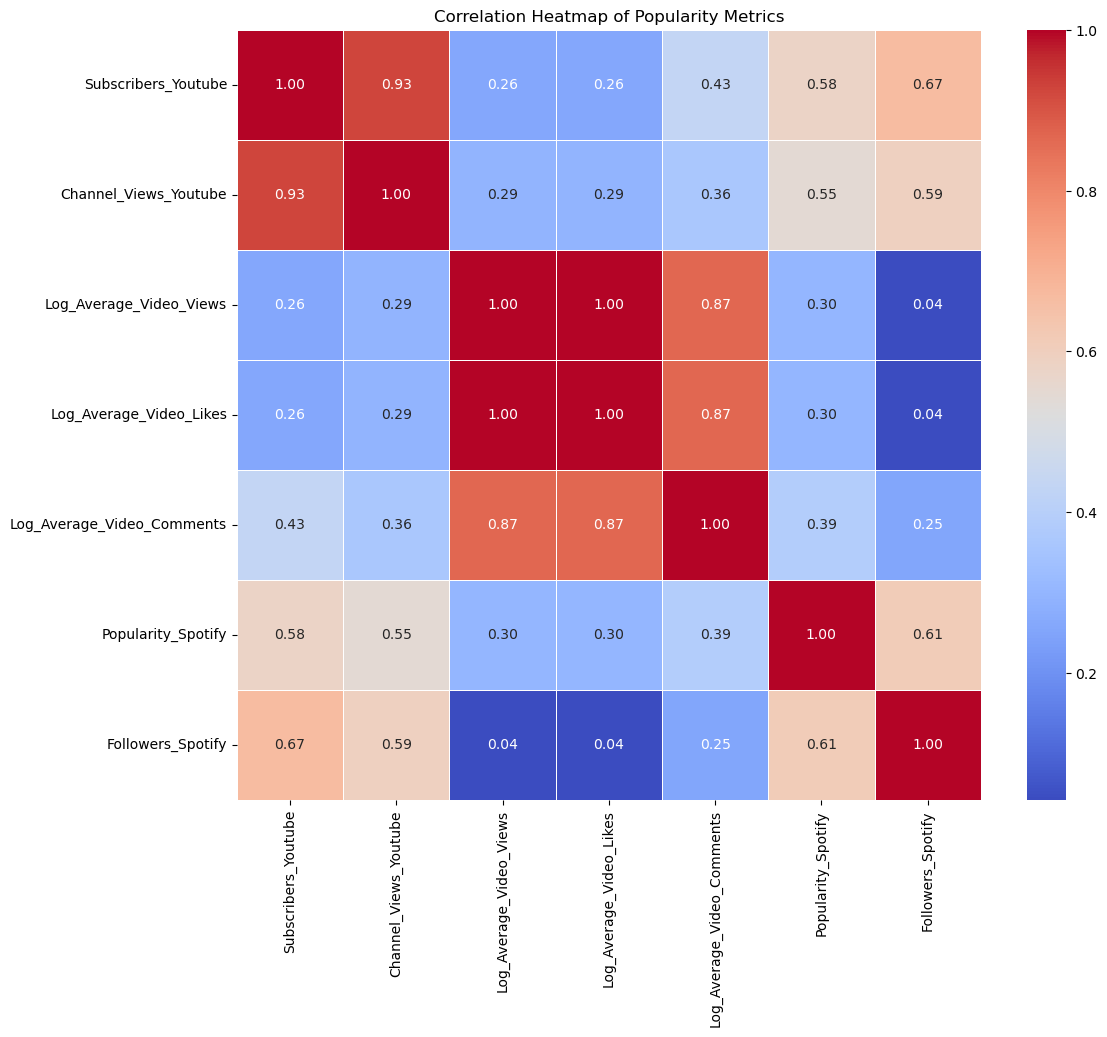

In [33]:
# Compute the correlation matrix
correlation_matrix = popularity_metrics[metrics_tests].corr()

# Print the correlation matrix
print(correlation_matrix)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Popularity Metrics')
plt.show()

In the above correlation matrix we can see the correlations between the different popularity metrics of YouTube and Spotify

- Subscribers & Channel Views on YouTube: There is a strong positive correlation between the number of subscribers and the channel views on YouTube, indicating that channels with higher numbers of subscribers also have more channel views.
- Subscribers on YouTube & Popularity on Spotify: There is a moderate positive correlation between the number of subscribers on YouTube and the popularity on Spotify, suggesting that artists with a high number of subscribers on YouTube also have a higher Popularity on Spotify.
- Subscribers on YouTube & Followers on Spotify: There is a moderate positive relationship between the number of subscribers on YouTube and the number of followers on Spotify, indicating that artists with higher numbers of subscribers on YouTube also have higher numbers of followers on Spotify. 
- Channel Views on YouTube & Popularity on Spotify: We can see a moderate positive correlation between the number of channel views on YouTube and the popularity on Spotify, suggesting that artists with a high number of channel views on YouTube also have a higher Popularity on Spotify.
- Channel Views on YouTube & Followers on Spotify: There is a moderate positive relationship between the number of channel views on YouTube and the number of followers on Spotify, indicating that artists with higher numbers of channel views on YouTube also have higher numbers of followers on Spotify. 
&rarr; these four correlations of metrics across the two platforms do make sense as i chose the top artists based on the charts of both platforms, so they should be popular on both platforms.
- Log Average Views per Video & Log Average Likes per Video on YouTube: These two metrics are perfectly correlated (1.00), which suggests that the average number of views and likes per video are consistently related.
- Log Average Views/Likes per Video & Log average comments per video on YouTube: Here we can see a strong positive correlation, meaning more views and likes per video also mean a higher number of comments below the video. 
- Popularity & Followers on Spotify: There is a moderate positive relationship between the popularity and the number of followers on Spotify, indicating that artists having a high popularity also have high numbers of followers on Spotify.

As we saw in the visualizations above the data for almost all metrics is not normally distributed. Therefore i will use the Mann-Whitney U Test and the permutation test to test if the differences in the metrics between male and female artists are statistically significant. Both of these tests are non-parametric, do not assume normal distributions and are suitable for small samples which is the case in my analysis.

Null Hypothesis (H₀): Female musicians have the same distribution of popularity metrics of Youtube and Spotify as male musicians. (No significant difference in popularity metrics.)

Alternative Hypothesis (H₁): Female musicians have a lower distribution of popularity metrics of Youtube and Spotify compared to male musicians. (Female musicians have significant lower popularity metrics.)

**Mann-Withney U Test**

Prerequisites:
- independence between the two groups
- continous/ordinal data
- distribution of the two groups is roughly the same

&rarr; fullfilled in my data, male and female are independent groups and the popularity metrics are numeric data. In the histograms we can see that both groups have similar shapes of distributions.

Eid, Gollwitzer, Schmitt (2017): Statistik und Forschungsmethoden: Lehrbuch. Mit Online-Material. Beltz.

In [80]:
# Save the male and female data in seperate DataFrames
male_data = popularity_metrics[popularity_metrics['Gender'] == 'male']
female_data = popularity_metrics[popularity_metrics['Gender'] == 'female']

# Perform Mann-Whitney U test for each metric
results_u_test = {}
for metric in metrics_tests:
    u_stat, p_value_u = stats.mannwhitneyu(female_data[metric], male_data[metric], alternative='less')
    results_u_test[metric] = {
        'U_Stat': u_stat,
        'p_value': p_value_u
    }

# Convert results to DataFrame and save to csv
u_test_results = pd.DataFrame(results_u_test).T
u_test_results.to_csv('popularity_metrics/withney_u_test_results.csv', index = False)
u_test_results

,U_Stat,p_value
Subscribers_Youtube,69.0,0.929767
Channel_Views_Youtube,58.0,0.739739
Log_Average_Video_Views,41.0,0.260261
Log_Average_Video_Likes,41.0,0.260261
Log_Average_Video_Comments,50.0,0.515075
Popularity_Spotify,43.5,0.323266
Followers_Spotify,59.0,0.763662


**Permutation Test**

In [81]:
def permutation_test(male_data, female_data, n_permutations=10000):
    '''
    Function to perform a one-sided permutation test to assess if the mean of the female group is 
    significantly less than the mean of the male group.
    
    Parameters
    ----------
    male_data: DataFrame
               Data for the male group.
    female_data: DataFrame
                 Data for the female group.
    n_permutations: Integer, optional (default=10000)
                    The number of permutations to perform for the test.
    
    Returns
    -------
    observed_mean_diff: Float
                        The observed difference in means between the female and male groups.
    p_value: Float
             The p-value of the permutation test, representing the proportion of permutations where 
             the permuted mean difference is less than or equal to the observed mean difference.
    '''
    # Define the observed test statistic 
    observed_mean_diff = np.mean(female_data) - np.mean(male_data)
    
    # Combine data
    combined_data = np.concatenate([male_data, female_data])
    n_female = len(female_data)
    
    # Permutation test
    permuted_diffs = []
    for _ in range(n_permutations):
        np.random.shuffle(combined_data)
        permuted_female = combined_data[:n_female]
        permuted_male = combined_data[n_female:]
        permuted_diff = np.mean(permuted_female) - np.mean(permuted_male)
        permuted_diffs.append(permuted_diff)
    
    # Calculate p-value
    permuted_diffs = np.array(permuted_diffs)
    p_value = np.mean(permuted_diffs <= observed_mean_diff)
    
    return observed_mean_diff, p_value


# Run permutation test for each metric
results_permutation_test = {}
for metric in metrics_tests:
    observed_mean_diff, p_value_permutation = permutation_test(male_data[metric].values, female_data[metric].values)
    results_permutation_test[metric] = {
        'Observed_Mean_Diff': observed_mean_diff,
        'p_value': p_value_permutation
    }

# Convert results to DataFrame and save to csv
permutation_test_results = pd.DataFrame(results_permutation_test).T
permutation_test_results.to_csv('popularity_metrics/permutation_tests_results.csv', index = False)
permutation_test_results

,Observed_Mean_Diff,p_value
Subscribers_Youtube,1.357710e+07,0.9212
Channel_Views_Youtube,4.304037e+09,0.7714
Log_Average_Video_Views,-4.870782e-01,0.2526
Log_Average_Video_Likes,-4.870782e-01,0.2469
Log_Average_Video_Comments,-7.790241e-02,0.4466
Popularity_Spotify,-4.000000e-01,0.4248
Followers_Spotify,4.967715e+06,0.6199


The results for all metrics in both tests show similar p-values. These p-values show that we can not reject the null hypothese. All p-values are clearly higher than 0.05. This means there is no significant difference in the popularity metrics of YouTube and Spotify between male and female artists. Female artists do not have statistically significant lower popularity metrics than male artists on YouTube and on Spotify.

**Step 5: Retrieve the comments below the videos of the Top 20 artists**

Retrieve the comments below the newest 20 videos of each artist on YouTube

In [82]:
# Split the channel ids into 4 parts to retrieve the comments in 4 parts because of api quota limit
# Read the CSV file with channel IDs
youtube_channel_data = pd.read_csv('popularity_metrics/youtube_channel_ids.csv')

# Split the DataFrame into 4 parts
split_dataframes = np.array_split(youtube_channel_data, 4)

# Save each part to a separate CSV file
for i, df_part in enumerate(split_dataframes):
    df_part.to_csv(f'retrieved_youtube_comments/youtube_channel_ids_part_{i + 1}.csv', index=False)

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [546]:
# Function to retrieve video statistics
def get_video_statistics(video_id, youtube):
    '''
    Retrieve the statistics of a specific video from YouTube.
    
    Parameters
    ----------
    video_id: String
              The ID of the YouTube video whose statistics are to be retrieved.
    youtube: Google API client
             An authenticated YouTube Data API client object.
    
    Returns
    -------
    statistics: Dictionary or None
                Containing statistics such as view count, like count, and comment count of the video.
                Returns None if the video is not found or if statistics are not available.
    '''
    request = youtube.videos().list(
        part='statistics',
        id=video_id
    )
    response = request.execute()
    if response['items']:
        return response['items'][0]['statistics']
    return None

# Function to retrieve comments for a given video ID
def get_video_comments(video_id, youtube):
    '''
    Retrieve all comments for a specific YouTube video.
    
    Parameters
    ----------
    video_id: String
              Video ID for which comments are to be retrieved.
    youtube: Google API client
             An authenticated YouTube Data API client object.
    
    Returns
    -------
    comments: List of Strings
              Containing the text of all top-level comments for the specified video.
    '''
    comments = []
    next_page_token = None
    
    while True:
        request = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=100,
            pageToken=next_page_token
        )
        
        response = request.execute()
        
        for item in response.get('items', []):
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)
        
        next_page_token = response.get('nextPageToken')
        
        if not next_page_token:
            break
    
    return comments

# Function to retrieve the 20 newest videos for a given channel ID
def get_newest_videos_for_channel(channel_id, youtube):
    '''
    Retrieve the 20 newest videos for a specific YouTube channel.
    
    Parameters
    ----------
    channel_id: String
                Channel ID for which the newest videos are to be retrieved.
    youtube: Google API client
             An authenticated YouTube Data API client object.
    
    Returns
    -------
    videos: List of Dictionaries
            Each containing the YouTube video ID and its comments for the 20 most recent videos 
            on the channel. Each dictionary includes:
                - 'YouTube_Channel_ID': The ID of the YouTube channel.
                - 'YouTube_Video_ID': The ID of the video.
                - 'Comments': A list of comments for the video.
    '''
                
    videos = []
    next_page_token = None
    
    request = youtube.search().list(
        part='snippet',
        channelId=channel_id,
        maxResults=20,  # Retrieve 20 newest videos
        order='date',
        type='video'
    )
    
    response = request.execute()
    
    # Collect video IDs and comments for each video
    for item in response.get('items', []):
        video_id = item['id']['videoId']
        stats = get_video_statistics(video_id, youtube)
        
        if stats and 'commentCount' in stats and int(stats['commentCount']) > 0:
            comments = get_video_comments(video_id, youtube)
            videos.append({
                'YouTube_Channel_ID': channel_id,
                'YouTube_Video_ID': video_id,
                'Comments': comments
            })
    
    return videos

In [555]:
# Initialize the API
youtube = build('youtube', 'v3', developerKey=api_key)

# Function to process a single part
def process_part(input_csv, output_csv):
    '''
    Function to process a part of the YouTube channel data to retrieve the 20 newest videos and their 
    comments for each channel listed in the input CSV file, and save the results to an output CSV file.
    
    Parameters
    ----------
    input_csv: String
               Path to the input CSV file containing YouTube channel IDs. 
    output_csv: String
                Path to the output CSV file where the results will be saved. 
    '''
    # Read the CSV file with channel IDs
    youtube_channel_data = pd.read_csv(input_csv)
    youtube_channel_ids = youtube_channel_data['YouTube_Channel_ID'].tolist()
    
    all_newest_videos = []
    
    # Process each channel ID
    for channel_id in youtube_channel_ids:
        videos = get_newest_videos_for_channel(channel_id, youtube)
        all_newest_videos.extend(videos)
    
    # Convert to pandas DataFrame for further analysis
    comments = pd.DataFrame(all_newest_videos)
    youtube_comments = comments.merge(youtube_channel_data, on='YouTube_Channel_ID')
    
    # Save the results to a new CSV file
    youtube_comments.to_csv(output_csv, index=False)

INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0


In [407]:
# Process each part and save the results
# Process the first part of the channels
process_part('retrieved_youtube_comments/youtube_channel_ids_part_1.csv', 'retrieved_youtube_comments/youtube_channel_ids_part_1_comments.csv')

In [83]:
# Reopen the comments
comments_part_1 = pd.read_csv('retrieved_youtube_comments/youtube_channel_ids_part_1_comments.csv')
comments_part_1

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist
0,UCmBA_wu8xGg1OfOkfW13Q0Q,ssdN7ZfavHs,['El q tenga mas like super mega gay en busca ...,Bad Bunny
1,UCmBA_wu8xGg1OfOkfW13Q0Q,0KEFzO4Po6I,"['Wao k bello eres ❤❤❤', 'Great song', 'A nooo...",Bad Bunny
2,UCmBA_wu8xGg1OfOkfW13Q0Q,QCqc3k0Tzbs,"['Por la herejia, blasfemia, sacrilegio, apost...",Bad Bunny
3,UCmBA_wu8xGg1OfOkfW13Q0Q,_PJvpq8uOZM,"['The ref of Charles Aznavour', '🔥🔥🔥🔥', 'Le ti...",Bad Bunny
4,UCmBA_wu8xGg1OfOkfW13Q0Q,c5wXFxiLabI,"['No me quiero casar con (ella)<br>🏁🤘👁🤘🏁', '🔥🔥...",Bad Bunny
...,...,...,...,...
95,UCfM3zsQsOnfWNUppiycmBuw,AuQ36zwFA3s,['Boy did we need slim shaddy love you marshal...,Eminem
96,UCfM3zsQsOnfWNUppiycmBuw,xVuYQCa9saw,['Thats not eminem... THAT&#39;S MF SLIM SHADY...,Eminem
97,UCfM3zsQsOnfWNUppiycmBuw,QZVEGqhfS20,"['Only song on the album I don’t like.', 'A bl...",Eminem
98,UCfM3zsQsOnfWNUppiycmBuw,drJ508gTslE,['I lost my dad 4 years ago. This song really ...,Eminem


In [88]:
# Add the number of comments to each video
comments_part_1['Comment_Count'] = comments_part_1['Comments'].apply(lambda x: len(eval(x)))  
comments_part_1

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist,Comment_Count
0,UCmBA_wu8xGg1OfOkfW13Q0Q,ssdN7ZfavHs,['El q tenga mas like super mega gay en busca ...,Bad Bunny,14077
1,UCmBA_wu8xGg1OfOkfW13Q0Q,0KEFzO4Po6I,"['Wao k bello eres ❤❤❤', 'Great song', 'A nooo...",Bad Bunny,16964
2,UCmBA_wu8xGg1OfOkfW13Q0Q,QCqc3k0Tzbs,"['Por la herejia, blasfemia, sacrilegio, apost...",Bad Bunny,15763
3,UCmBA_wu8xGg1OfOkfW13Q0Q,_PJvpq8uOZM,"['The ref of Charles Aznavour', '🔥🔥🔥🔥', 'Le ti...",Bad Bunny,33302
4,UCmBA_wu8xGg1OfOkfW13Q0Q,c5wXFxiLabI,"['No me quiero casar con (ella)<br>🏁🤘👁🤘🏁', '🔥🔥...",Bad Bunny,4674
...,...,...,...,...,...
95,UCfM3zsQsOnfWNUppiycmBuw,AuQ36zwFA3s,['Boy did we need slim shaddy love you marshal...,Eminem,6329
96,UCfM3zsQsOnfWNUppiycmBuw,xVuYQCa9saw,['Thats not eminem... THAT&#39;S MF SLIM SHADY...,Eminem,8239
97,UCfM3zsQsOnfWNUppiycmBuw,QZVEGqhfS20,"['Only song on the album I don’t like.', 'A bl...",Eminem,3649
98,UCfM3zsQsOnfWNUppiycmBuw,drJ508gTslE,['I lost my dad 4 years ago. This song really ...,Eminem,9541


In [89]:
# Check if there are videos without comments
videos_without_comments_1 = comments_part_1[comments_part_1['Comment_Count'] == 0]

videos_without_comments_1

# -> there are none

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist,Comment_Count


In [451]:
# Process the second part of the channels
process_part('retrieved_youtube_comments/youtube_channel_ids_part_2.csv', 'retrieved_youtube_comments/youtube_channel_ids_part_2_comments.csv')

In [84]:
# Reopen the comments
comments_part_2 = pd.read_csv('retrieved_youtube_comments/youtube_channel_ids_part_2_comments.csv')
comments_part_2

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist
0,UCZuPJZ2kGFdlbQu1qotZaHw,WGUVi7gyzQQ,['Ptm a veces pienso si ella tbn piensa en mi ...,KAROL G
1,UCZuPJZ2kGFdlbQu1qotZaHw,xveMJiihGtI,"['Karol g dame tu número❤', 'Karol g te amo y ...",KAROL G
2,UCZuPJZ2kGFdlbQu1qotZaHw,cZ-1bTsbSws,"['❤❤❤❤', 'Ven a república dominicana plis soy...",KAROL G
3,UCZuPJZ2kGFdlbQu1qotZaHw,ob199IWu6Ts,"['Em soy de puerto Rico', 'Te amo karol', 'Kar...",KAROL G
4,UCZuPJZ2kGFdlbQu1qotZaHw,BM--8EyM4lw,"['Ese es tu hija Karol G', 'Te amo karol ❤', '...",KAROL G
...,...,...,...,...
95,UC3lBXcrKFnFAFkfVk5WuKcQ,C_s9JJnqQqM,"['Give me the keys bro', 'This is the only goo...",Kendrick Lamar
96,UC3lBXcrKFnFAFkfVk5WuKcQ,Vo89NfFYKKI,['The worst part about the beef is the fact th...,Kendrick Lamar
97,UC3lBXcrKFnFAFkfVk5WuKcQ,HTAQxUXq674,"['MR MORALE GIVE ME HIGH FIVE 🗣️', 'Praise the...",Kendrick Lamar
98,UC3lBXcrKFnFAFkfVk5WuKcQ,-vrhf1P9zwc,"['buck broken', 'I know it&#39;s probably been...",Kendrick Lamar


In [569]:
# Add the number of comments to each video
comments_part_2['Comment_Count'] = comments_part_2['Comments'].apply(lambda x: len(eval(x))) 
comments_part_2

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist,Comment_Count
0,UCZuPJZ2kGFdlbQu1qotZaHw,WGUVi7gyzQQ,['Ptm a veces pienso si ella tbn piensa en mi ...,KAROL G,947
1,UCZuPJZ2kGFdlbQu1qotZaHw,xveMJiihGtI,"['Karol g dame tu número❤', 'Karol g te amo y ...",KAROL G,405
2,UCZuPJZ2kGFdlbQu1qotZaHw,cZ-1bTsbSws,"['❤❤❤❤', 'Ven a república dominicana plis soy...",KAROL G,1323
3,UCZuPJZ2kGFdlbQu1qotZaHw,ob199IWu6Ts,"['Em soy de puerto Rico', 'Te amo karol', 'Kar...",KAROL G,23925
4,UCZuPJZ2kGFdlbQu1qotZaHw,BM--8EyM4lw,"['Ese es tu hija Karol G', 'Te amo karol ❤', '...",KAROL G,30291
...,...,...,...,...,...
95,UC3lBXcrKFnFAFkfVk5WuKcQ,C_s9JJnqQqM,"['Give me the keys bro', 'This is the only goo...",Kendrick Lamar,12676
96,UC3lBXcrKFnFAFkfVk5WuKcQ,Vo89NfFYKKI,['The worst part about the beef is the fact th...,Kendrick Lamar,6218
97,UC3lBXcrKFnFAFkfVk5WuKcQ,HTAQxUXq674,"['MR MORALE GIVE ME HIGH FIVE 🗣️', 'Praise the...",Kendrick Lamar,3601
98,UC3lBXcrKFnFAFkfVk5WuKcQ,-vrhf1P9zwc,"['buck broken', 'I know it&#39;s probably been...",Kendrick Lamar,3087


In [576]:
# Check if there are videos without comments
videos_without_comments_2 = comments_part_2[comments_part_2['Comment_Count'] == 0]

videos_without_comments_2

# -> there are none

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist,Comment_Count


In [532]:
# Process the third part of the channels
process_part('retrieved_youtube_comments/youtube_channel_ids_part_3.csv', 'retrieved_youtube_comments/youtube_channel_ids_part_3_comments.csv')

In [85]:
# Reopen the comments
comments_part_3 = pd.read_csv('retrieved_youtube_comments/youtube_channel_ids_part_3_comments.csv')
comments_part_3

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist
0,UCRRmSKkhOKEO6vIBaxG-ejA,LmweChiEKiQ,['Mexico se esta convirtiendo el lo más popula...,Junior H
1,UCRRmSKkhOKEO6vIBaxG-ejA,A9M8j9MKl7I,"['I really miss gf 😢😢', 'No me gustan las cans...",Junior H
2,UCRRmSKkhOKEO6vIBaxG-ejA,7JEIsrAL9xQ,"['🖤', 'Masones', '💃🏻_____✍🏻', 'Qué hermosa can...",Junior H
3,UCRRmSKkhOKEO6vIBaxG-ejA,EvLt-Xj9Pjg,['Junior sabe como darnos en la madre 🥲❤️\u200...,Junior H
4,UCRRmSKkhOKEO6vIBaxG-ejA,eUX086mraqc,['El que no quiera que junior h deje de Catar ...,Junior H
...,...,...,...,...
92,UCPKWE1H6xhxwPlqUlKgHb_w,s68RvIlwhwg,"['Desde <a href=""https://www.youtube.com/watch...",Sabrina Carpenter
93,UCPKWE1H6xhxwPlqUlKgHb_w,DKB-1EV5qHw,"['cool😊', 'Desde <a href=""https://www.youtube....",Sabrina Carpenter
94,UCPKWE1H6xhxwPlqUlKgHb_w,h4Jrphn8kgc,"['שיר ממש יפה❤❤', 'Yy❤', 'Dios mio la creativi...",Sabrina Carpenter
95,UCPKWE1H6xhxwPlqUlKgHb_w,D2tuEMpiG7w,"['<a href=""https://www.youtube.com/watch?v=D2t...",Sabrina Carpenter


Note: For Pritam i only got 17 videos instead of 20, this is because these are the only videos on the channel that have comments

In [572]:
# Add the number of comments to each video
comments_part_3['Comment_Count'] = comments_part_3['Comments'].apply(lambda x: len(eval(x))) 
comments_part_3

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist,Comment_Count
0,UCRRmSKkhOKEO6vIBaxG-ejA,LmweChiEKiQ,['Mexico se esta convirtiendo el lo más popula...,Junior H,7952
1,UCRRmSKkhOKEO6vIBaxG-ejA,A9M8j9MKl7I,"['I really miss gf 😢😢', 'No me gustan las cans...",Junior H,2323
2,UCRRmSKkhOKEO6vIBaxG-ejA,7JEIsrAL9xQ,"['🖤', 'Masones', '💃🏻_____✍🏻', 'Qué hermosa can...",Junior H,506
3,UCRRmSKkhOKEO6vIBaxG-ejA,EvLt-Xj9Pjg,['Junior sabe como darnos en la madre 🥲❤️\u200...,Junior H,303
4,UCRRmSKkhOKEO6vIBaxG-ejA,eUX086mraqc,['El que no quiera que junior h deje de Catar ...,Junior H,277
...,...,...,...,...,...
92,UCPKWE1H6xhxwPlqUlKgHb_w,s68RvIlwhwg,"['Desde <a href=""https://www.youtube.com/watch...",Sabrina Carpenter,238
93,UCPKWE1H6xhxwPlqUlKgHb_w,DKB-1EV5qHw,"['cool😊', 'Desde <a href=""https://www.youtube....",Sabrina Carpenter,651
94,UCPKWE1H6xhxwPlqUlKgHb_w,h4Jrphn8kgc,"['שיר ממש יפה❤❤', 'Yy❤', 'Dios mio la creativi...",Sabrina Carpenter,308
95,UCPKWE1H6xhxwPlqUlKgHb_w,D2tuEMpiG7w,"['<a href=""https://www.youtube.com/watch?v=D2t...",Sabrina Carpenter,282


In [577]:
# Check if there are videos without comments
videos_without_comments_3 = comments_part_3[comments_part_3['Comment_Count'] == 0]

videos_without_comments_3

# -> there are none

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist,Comment_Count


In [548]:
# Process the fourth part of the channels
process_part('retrieved_youtube_comments/youtube_channel_ids_part_4.csv', 'retrieved_youtube_comments/youtube_channel_ids_part_4_comments.csv')

In [86]:
# Reopen the comments
comments_part_4 = pd.read_csv('retrieved_youtube_comments/youtube_channel_ids_part_4_comments.csv')
comments_part_4

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist
0,UCYLNGLIzMhRTi6ZOLjAPSmw,P1jGg5nMoyc,"['Love u sakira❣️love from Bangladesh', 'esa f...",Shakira
1,UCYLNGLIzMhRTi6ZOLjAPSmw,ZuUpI1nKAOE,"['Estamos Como el meme ( han pasado 84 años)',...",Shakira
2,UCYLNGLIzMhRTi6ZOLjAPSmw,GQdNXA2ufxc,"['😙😙😙😙😙😙😅', 'Ermasa Shakira ❤❤❤', 'Una pregunt...",Shakira
3,UCYLNGLIzMhRTi6ZOLjAPSmw,KPCA_h_53zk,"['Eres la mejor', 'Very nice ...!<br><br>❤❤❤❤❤...",Shakira
4,UCYLNGLIzMhRTi6ZOLjAPSmw,UYGmwJDbmKU,"['😮😮😮', 'Shakira es la mejor ❤❤', 'Ah Shakira ...",Shakira
...,...,...,...,...
95,UC-J-KZfRV8c13fOCkhXdLiQ,K5d9BDzIuB4,"['Unfair dressed fashion here', 'How many inte...",Dua Lipa
96,UC-J-KZfRV8c13fOCkhXdLiQ,msypPPiz7dU,"['me identifico tanto com essa música ❤😅', '✍️...",Dua Lipa
97,UC-J-KZfRV8c13fOCkhXdLiQ,RN6cnF16B1A,"['😘', 'Orgazm', 'Dejame decirte algo, te me ap...",Dua Lipa
98,UC-J-KZfRV8c13fOCkhXdLiQ,8wJoYFbbuZc,"['عالی زیبای خفته 💞', 'I use this to practice🥲...",Dua Lipa


In [575]:
# Add the number of comments to each video
comments_part_4['Comment_Count'] = comments_part_4['Comments'].apply(lambda x: len(eval(x))) 
comments_part_4

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist,Comment_Count
0,UCYLNGLIzMhRTi6ZOLjAPSmw,P1jGg5nMoyc,"['Love u sakira❣️love from Bangladesh', 'esa f...",Shakira,7774
1,UCYLNGLIzMhRTi6ZOLjAPSmw,ZuUpI1nKAOE,"['Estamos Como el meme ( han pasado 84 años)',...",Shakira,867
2,UCYLNGLIzMhRTi6ZOLjAPSmw,GQdNXA2ufxc,"['😙😙😙😙😙😙😅', 'Ermasa Shakira ❤❤❤', 'Una pregunt...",Shakira,1429
3,UCYLNGLIzMhRTi6ZOLjAPSmw,KPCA_h_53zk,"['Eres la mejor', 'Very nice ...!<br><br>❤❤❤❤❤...",Shakira,923
4,UCYLNGLIzMhRTi6ZOLjAPSmw,UYGmwJDbmKU,"['😮😮😮', 'Shakira es la mejor ❤❤', 'Ah Shakira ...",Shakira,442
...,...,...,...,...,...
95,UC-J-KZfRV8c13fOCkhXdLiQ,K5d9BDzIuB4,"['Unfair dressed fashion here', 'How many inte...",Dua Lipa,951
96,UC-J-KZfRV8c13fOCkhXdLiQ,msypPPiz7dU,"['me identifico tanto com essa música ❤😅', '✍️...",Dua Lipa,595
97,UC-J-KZfRV8c13fOCkhXdLiQ,RN6cnF16B1A,"['😘', 'Orgazm', 'Dejame decirte algo, te me ap...",Dua Lipa,567
98,UC-J-KZfRV8c13fOCkhXdLiQ,8wJoYFbbuZc,"['عالی زیبای خفته 💞', 'I use this to practice🥲...",Dua Lipa,321


In [578]:
# Check if there are videos without comments
videos_without_comments_4 = comments_part_4[comments_part_4['Comment_Count'] == 0]

videos_without_comments_4

# -> there are none

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist,Comment_Count


In [579]:
# Concatenate all parts into a single DataFrame
youtube_comments = pd.concat([comments_part_1, comments_part_2, comments_part_3, comments_part_4])

# Display the combined DataFrame
youtube_comments

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist,Comment_Count
0,UCmBA_wu8xGg1OfOkfW13Q0Q,ssdN7ZfavHs,['El q tenga mas like super mega gay en busca ...,Bad Bunny,14077
1,UCmBA_wu8xGg1OfOkfW13Q0Q,0KEFzO4Po6I,"['Wao k bello eres ❤❤❤', 'Great song', 'A nooo...",Bad Bunny,16964
2,UCmBA_wu8xGg1OfOkfW13Q0Q,QCqc3k0Tzbs,"['Por la herejia, blasfemia, sacrilegio, apost...",Bad Bunny,15763
3,UCmBA_wu8xGg1OfOkfW13Q0Q,_PJvpq8uOZM,"['The ref of Charles Aznavour', '🔥🔥🔥🔥', 'Le ti...",Bad Bunny,33302
4,UCmBA_wu8xGg1OfOkfW13Q0Q,c5wXFxiLabI,"['No me quiero casar con (ella)<br>🏁🤘👁🤘🏁', '🔥🔥...",Bad Bunny,4674
...,...,...,...,...,...
95,UC-J-KZfRV8c13fOCkhXdLiQ,K5d9BDzIuB4,"['Unfair dressed fashion here', 'How many inte...",Dua Lipa,951
96,UC-J-KZfRV8c13fOCkhXdLiQ,msypPPiz7dU,"['me identifico tanto com essa música ❤😅', '✍️...",Dua Lipa,595
97,UC-J-KZfRV8c13fOCkhXdLiQ,RN6cnF16B1A,"['😘', 'Orgazm', 'Dejame decirte algo, te me ap...",Dua Lipa,567
98,UC-J-KZfRV8c13fOCkhXdLiQ,8wJoYFbbuZc,"['عالی زیبای خفته 💞', 'I use this to practice🥲...",Dua Lipa,321


In [580]:
# Calculate the total number of comments across all videos
total_comments = youtube_comments['Comment_Count'].sum()

# Print the total number of comments
print(f"Total number of comments across all videos: {total_comments}")

Total number of comments across all videos: 1954594


In [581]:
# Reopen the top20 file to get the gender of the artist
top_20 = pd.read_csv('top_artists/top_20_artists.csv')

In [582]:
# Merge the retrieved comments with the top20 DataFrame to get the gender of each artist
youtube_comments = youtube_comments.merge(top_20, on = 'Artist')
youtube_comments

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist,Comment_Count,Gender
0,UCmBA_wu8xGg1OfOkfW13Q0Q,ssdN7ZfavHs,['El q tenga mas like super mega gay en busca ...,Bad Bunny,14077,male
1,UCmBA_wu8xGg1OfOkfW13Q0Q,0KEFzO4Po6I,"['Wao k bello eres ❤❤❤', 'Great song', 'A nooo...",Bad Bunny,16964,male
2,UCmBA_wu8xGg1OfOkfW13Q0Q,QCqc3k0Tzbs,"['Por la herejia, blasfemia, sacrilegio, apost...",Bad Bunny,15763,male
3,UCmBA_wu8xGg1OfOkfW13Q0Q,_PJvpq8uOZM,"['The ref of Charles Aznavour', '🔥🔥🔥🔥', 'Le ti...",Bad Bunny,33302,male
4,UCmBA_wu8xGg1OfOkfW13Q0Q,c5wXFxiLabI,"['No me quiero casar con (ella)<br>🏁🤘👁🤘🏁', '🔥🔥...",Bad Bunny,4674,male
...,...,...,...,...,...,...
392,UC-J-KZfRV8c13fOCkhXdLiQ,K5d9BDzIuB4,"['Unfair dressed fashion here', 'How many inte...",Dua Lipa,951,female
393,UC-J-KZfRV8c13fOCkhXdLiQ,msypPPiz7dU,"['me identifico tanto com essa música ❤😅', '✍️...",Dua Lipa,595,female
394,UC-J-KZfRV8c13fOCkhXdLiQ,RN6cnF16B1A,"['😘', 'Orgazm', 'Dejame decirte algo, te me ap...",Dua Lipa,567,female
395,UC-J-KZfRV8c13fOCkhXdLiQ,8wJoYFbbuZc,"['عالی زیبای خفته 💞', 'I use this to practice🥲...",Dua Lipa,321,female


In [583]:
# Save all comments to csv
youtube_comments.to_csv('retrieved_youtube_comments/all_youtube_comments.csv', index = False)

In [90]:
# Reopen the comments
youtube_comments = pd.read_csv('retrieved_youtube_comments/all_youtube_comments.csv')
youtube_comments

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist,Comment_Count,Gender
0,UCmBA_wu8xGg1OfOkfW13Q0Q,ssdN7ZfavHs,['El q tenga mas like super mega gay en busca ...,Bad Bunny,14077,male
1,UCmBA_wu8xGg1OfOkfW13Q0Q,0KEFzO4Po6I,"['Wao k bello eres ❤❤❤', 'Great song', 'A nooo...",Bad Bunny,16964,male
2,UCmBA_wu8xGg1OfOkfW13Q0Q,QCqc3k0Tzbs,"['Por la herejia, blasfemia, sacrilegio, apost...",Bad Bunny,15763,male
3,UCmBA_wu8xGg1OfOkfW13Q0Q,_PJvpq8uOZM,"['The ref of Charles Aznavour', '🔥🔥🔥🔥', 'Le ti...",Bad Bunny,33302,male
4,UCmBA_wu8xGg1OfOkfW13Q0Q,c5wXFxiLabI,"['No me quiero casar con (ella)<br>🏁🤘👁🤘🏁', '🔥🔥...",Bad Bunny,4674,male
...,...,...,...,...,...,...
392,UC-J-KZfRV8c13fOCkhXdLiQ,K5d9BDzIuB4,"['Unfair dressed fashion here', 'How many inte...",Dua Lipa,951,female
393,UC-J-KZfRV8c13fOCkhXdLiQ,msypPPiz7dU,"['me identifico tanto com essa música ❤😅', '✍️...",Dua Lipa,595,female
394,UC-J-KZfRV8c13fOCkhXdLiQ,RN6cnF16B1A,"['😘', 'Orgazm', 'Dejame decirte algo, te me ap...",Dua Lipa,567,female
395,UC-J-KZfRV8c13fOCkhXdLiQ,8wJoYFbbuZc,"['عالی زیبای خفته 💞', 'I use this to practice🥲...",Dua Lipa,321,female


**Step 6: Clean and Preprocess the Comments**

In [119]:
def preprocess_comment(comment):
    '''
    Function to preprocess comments
    
    Parameters
    ----------
    comment: String
             Comment that should be preprocessed
    
    Returns
    -------
    cleaned_comment: String
                     Cleaned comment (removed HTML tags and URLs, converted to lowercase, tokenized into single words and joined back into one string)
    '''
    
    # Ensure the input is a string
    comment = str(comment)
    
    # Remove HTML tags
    comment = BeautifulSoup(comment, 'html.parser').get_text()
    
    # Remove URLs
    comment = re.sub(r'http\S+|www\S+|https\S+', '', comment, flags=re.MULTILINE)

    # Convert to lowercase
    comment = comment.lower()
    
    # Tokenize
    tokens = word_tokenize(comment)
    
    # Join tokens back into a single string
    cleaned_comment = ' '.join(tokens)
    
    return cleaned_comment

In [120]:
# Apply the preprocessing to the Comments
youtube_comments['Cleaned_Comments'] = youtube_comments['Comments'].apply(lambda comments: [preprocess_comment(c) for c in eval(comments)])
youtube_comments

C:\Users\carag\AppData\Local\Temp\ipykernel_31420\1517942732.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.















  comment = BeautifulSoup(comment, 'html.parser').get_text()















C:\Users\carag\AppData\Local\Temp\ipykernel_31420\1517942732.py:7: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.















  comment = BeautifulSoup(comment, 'html.parser').get_text()


,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist,Comment_Count,Gender,Cleaned_Comments
0,UCmBA_wu8xGg1OfOkfW13Q0Q,ssdN7ZfavHs,['El q tenga mas like super mega gay en busca ...,Bad Bunny,14077,male,[el q tenga mas like super mega gay en busca d...
1,UCmBA_wu8xGg1OfOkfW13Q0Q,0KEFzO4Po6I,"['Wao k bello eres ❤❤❤', 'Great song', 'A nooo...",Bad Bunny,16964,male,"[wao k bello eres ❤❤❤, great song, a noooo esc..."
2,UCmBA_wu8xGg1OfOkfW13Q0Q,QCqc3k0Tzbs,"['Por la herejia, blasfemia, sacrilegio, apost...",Bad Bunny,15763,male,"[por la herejia , blasfemia , sacrilegio , apo..."
3,UCmBA_wu8xGg1OfOkfW13Q0Q,_PJvpq8uOZM,"['The ref of Charles Aznavour', '🔥🔥🔥🔥', 'Le ti...",Bad Bunny,33302,male,"[the ref of charles aznavour, 🔥🔥🔥🔥, le tira a ..."
4,UCmBA_wu8xGg1OfOkfW13Q0Q,c5wXFxiLabI,"['No me quiero casar con (ella)<br>🏁🤘👁🤘🏁', '🔥🔥...",Bad Bunny,4674,male,"[no me quiero casar con ( ella ) 🏁🤘👁🤘🏁, 🔥🔥🔥, e..."
...,...,...,...,...,...,...,...
392,UC-J-KZfRV8c13fOCkhXdLiQ,K5d9BDzIuB4,"['Unfair dressed fashion here', 'How many inte...",Dua Lipa,951,female,"[unfair dressed fashion here, how many interna..."
393,UC-J-KZfRV8c13fOCkhXdLiQ,msypPPiz7dU,"['me identifico tanto com essa música ❤😅', '✍️...",Dua Lipa,595,female,"[me identifico tanto com essa música ❤😅, ✍️🪶🧜🐝..."
394,UC-J-KZfRV8c13fOCkhXdLiQ,RN6cnF16B1A,"['😘', 'Orgazm', 'Dejame decirte algo, te me ap...",Dua Lipa,567,female,"[😘, orgazm, dejame decirte algo , te me aparec..."
395,UC-J-KZfRV8c13fOCkhXdLiQ,8wJoYFbbuZc,"['عالی زیبای خفته 💞', 'I use this to practice🥲...",Dua Lipa,321,female,"[عالی زیبای خفته 💞, i use this to practice🥲❤️‍..."


In [121]:
# Check the original comments and the cleaned output
print(youtube_comments['Comments'].head(30))  
print(youtube_comments['Cleaned_Comments'].head(30)) 

0     ['El q tenga mas like super mega gay en busca ...















1     ['Wao k bello eres ❤❤❤', 'Great song', 'A nooo...















2     ['Por la herejia, blasfemia, sacrilegio, apost...















3     ['The ref of Charles Aznavour', '🔥🔥🔥🔥', 'Le ti...















4     ['No me quiero casar con (ella)<br>🏁🤘👁🤘🏁', '🔥🔥...















5     ['2.10', '2005 arecibo job corps 😭', 'Duro😛😛💔🪩...















6     ['el signo del dinero ese es mi nuevo zodiaco'...















7     ['La mejor intro en la historia del género urb...















8     ['Instrumental very similar to codeine crazy',...















9     ['money way', 'Like los fans de anuel q estamo...















10    ['Bad bunny and feid are the best', '🎉🎉🎉🎉🎉', '...















11    ['Y LO MEJOR YA TE PASO💥💥💥', 'Gracias por esto...















12    ['El tema mas duro, del carro mas garbage 🗿🗿💪🔥...















13    ['Que asco de cancion', 'Burlao', '04-08-24 .....















14    

In [122]:
# Count the numer of cleaned comments
youtube_comments['Cleaned_Comments_Count'] = youtube_comments['Cleaned_Comments'].apply(len) 
youtube_comments

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist,Comment_Count,Gender,Cleaned_Comments,Cleaned_Comments_Count
0,UCmBA_wu8xGg1OfOkfW13Q0Q,ssdN7ZfavHs,['El q tenga mas like super mega gay en busca ...,Bad Bunny,14077,male,[el q tenga mas like super mega gay en busca d...,14077
1,UCmBA_wu8xGg1OfOkfW13Q0Q,0KEFzO4Po6I,"['Wao k bello eres ❤❤❤', 'Great song', 'A nooo...",Bad Bunny,16964,male,"[wao k bello eres ❤❤❤, great song, a noooo esc...",16964
2,UCmBA_wu8xGg1OfOkfW13Q0Q,QCqc3k0Tzbs,"['Por la herejia, blasfemia, sacrilegio, apost...",Bad Bunny,15763,male,"[por la herejia , blasfemia , sacrilegio , apo...",15763
3,UCmBA_wu8xGg1OfOkfW13Q0Q,_PJvpq8uOZM,"['The ref of Charles Aznavour', '🔥🔥🔥🔥', 'Le ti...",Bad Bunny,33302,male,"[the ref of charles aznavour, 🔥🔥🔥🔥, le tira a ...",33302
4,UCmBA_wu8xGg1OfOkfW13Q0Q,c5wXFxiLabI,"['No me quiero casar con (ella)<br>🏁🤘👁🤘🏁', '🔥🔥...",Bad Bunny,4674,male,"[no me quiero casar con ( ella ) 🏁🤘👁🤘🏁, 🔥🔥🔥, e...",4674
...,...,...,...,...,...,...,...,...
392,UC-J-KZfRV8c13fOCkhXdLiQ,K5d9BDzIuB4,"['Unfair dressed fashion here', 'How many inte...",Dua Lipa,951,female,"[unfair dressed fashion here, how many interna...",951
393,UC-J-KZfRV8c13fOCkhXdLiQ,msypPPiz7dU,"['me identifico tanto com essa música ❤😅', '✍️...",Dua Lipa,595,female,"[me identifico tanto com essa música ❤😅, ✍️🪶🧜🐝...",595
394,UC-J-KZfRV8c13fOCkhXdLiQ,RN6cnF16B1A,"['😘', 'Orgazm', 'Dejame decirte algo, te me ap...",Dua Lipa,567,female,"[😘, orgazm, dejame decirte algo , te me aparec...",567
395,UC-J-KZfRV8c13fOCkhXdLiQ,8wJoYFbbuZc,"['عالی زیبای خفته 💞', 'I use this to practice🥲...",Dua Lipa,321,female,"[عالی زیبای خفته 💞, i use this to practice🥲❤️‍...",321


In [85]:
# Save the cleaned comments to csv
youtube_comments.to_csv('cleaned_comments/cleaned_youtube_comments.csv', index = False)

In [124]:
# Set seed to ensure reproducibility
DetectorFactory.seed = 0

# Function to detect if a comment is written in english
def is_english(comment):
    '''
    Function to detect if a comment is written in English.

    Parameters
    ----------
    comment: String
             The comment that should be checked for English language.

    Returns
    -------
    True/False: Boolean
                True if the comment is detected as English, False otherwise.
    '''
    try:
        # Detect the language of the comment
        return detect(comment) == 'en'
    except LangDetectException:
        # If the detection fails, assume it's not English
        return False

# Save the comments that are English in a new column
youtube_comments['English_Comments'] = youtube_comments['Cleaned_Comments'].apply(lambda x: [c for c in x if is_english(c)])

In [125]:
# Display the DataFrame
youtube_comments

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist,Comment_Count,Gender,Cleaned_Comments,Cleaned_Comments_Count,English_Comments
0,UCmBA_wu8xGg1OfOkfW13Q0Q,ssdN7ZfavHs,['El q tenga mas like super mega gay en busca ...,Bad Bunny,14077,male,[el q tenga mas like super mega gay en busca d...,14077,"[love from india❤🇮🇳, listening from zimbabwe 🇿..."
1,UCmBA_wu8xGg1OfOkfW13Q0Q,0KEFzO4Po6I,"['Wao k bello eres ❤❤❤', 'Great song', 'A nooo...",Bad Bunny,16964,male,"[wao k bello eres ❤❤❤, great song, a noooo esc...",16964,"[benito haceme 2 pibes soy el iwan, me every t..."
2,UCmBA_wu8xGg1OfOkfW13Q0Q,QCqc3k0Tzbs,"['Por la herejia, blasfemia, sacrilegio, apost...",Bad Bunny,15763,male,"[por la herejia , blasfemia , sacrilegio , apo...",15763,[if you ’ re going to alude to the bible and t...
3,UCmBA_wu8xGg1OfOkfW13Q0Q,_PJvpq8uOZM,"['The ref of Charles Aznavour', '🔥🔥🔥🔥', 'Le ti...",Bad Bunny,33302,male,"[the ref of charles aznavour, 🔥🔥🔥🔥, le tira a ...",33302,"[the ref of charles aznavour, did n't anybody ..."
4,UCmBA_wu8xGg1OfOkfW13Q0Q,c5wXFxiLabI,"['No me quiero casar con (ella)<br>🏁🤘👁🤘🏁', '🔥🔥...",Bad Bunny,4674,male,"[no me quiero casar con ( ella ) 🏁🤘👁🤘🏁, 🔥🔥🔥, e...",4674,"[❤teamo❤😂😊, very very nice.badbunny lives ever..."
...,...,...,...,...,...,...,...,...,...
392,UC-J-KZfRV8c13fOCkhXdLiQ,K5d9BDzIuB4,"['Unfair dressed fashion here', 'How many inte...",Dua Lipa,951,female,"[unfair dressed fashion here, how many interna...",951,"[unfair dressed fashion here, how many interna..."
393,UC-J-KZfRV8c13fOCkhXdLiQ,msypPPiz7dU,"['me identifico tanto com essa música ❤😅', '✍️...",Dua Lipa,595,female,"[me identifico tanto com essa música ❤😅, ✍️🪶🧜🐝...",595,[not usually my kind of music but ❤ this song ...
394,UC-J-KZfRV8c13fOCkhXdLiQ,RN6cnF16B1A,"['😘', 'Orgazm', 'Dejame decirte algo, te me ap...",Dua Lipa,567,female,"[😘, orgazm, dejame decirte algo , te me aparec...",567,"[she has at most bigger heands in the world, f..."
395,UC-J-KZfRV8c13fOCkhXdLiQ,8wJoYFbbuZc,"['عالی زیبای خفته 💞', 'I use this to practice🥲...",Dua Lipa,321,female,"[عالی زیبای خفته 💞, i use this to practice🥲❤️‍...",321,"[i use this to practice🥲❤️‍🔥, she has soul ! !..."


In [126]:
# Check the cleaned comments vs. the english comments
print(youtube_comments['Cleaned_Comments'].head(50)) 
print(youtube_comments['English_Comments'].head(50)) 

0     [el q tenga mas like super mega gay en busca d...















1     [wao k bello eres ❤❤❤, great song, a noooo esc...















2     [por la herejia , blasfemia , sacrilegio , apo...















3     [the ref of charles aznavour, 🔥🔥🔥🔥, le tira a ...















4     [no me quiero casar con ( ella ) 🏁🤘👁🤘🏁, 🔥🔥🔥, e...















5     [2.10, 2005 arecibo job corps 😭, duro😛😛💔🪩😖🍭, a...















6     [el signo del dinero ese es mi nuevo zodiaco, ...















7     [la mejor intro en la historia del género urba...















8     [instrumental very similar to codeine crazy, b...















9     [money way, like los fans de anuel q estamos a...















10    [bad bunny and feid are the best, 🎉🎉🎉🎉🎉, wtf ?...















11    [y lo mejor ya te paso💥💥💥, gracias por estos r...















12    [el tema mas duro , del carro mas garbage 🗿🗿💪🔥...















13    [que asco de cancion, burlao, 04-08-24 .... y ...















14    

Note: As we can see the language detection does not work perfectly, but as I have a large number of comments I decided to keep it like that, with some comments in other languages.

In [127]:
# Add the number of comments in english
youtube_comments['Comment_Count_English'] = youtube_comments['English_Comments'].apply(len) 

In [129]:
# Display the DataFrame
youtube_comments

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist,Comment_Count,Gender,Cleaned_Comments,Cleaned_Comments_Count,English_Comments,Comment_Count_English
0,UCmBA_wu8xGg1OfOkfW13Q0Q,ssdN7ZfavHs,['El q tenga mas like super mega gay en busca ...,Bad Bunny,14077,male,[el q tenga mas like super mega gay en busca d...,14077,"[love from india❤🇮🇳, listening from zimbabwe 🇿...",504
1,UCmBA_wu8xGg1OfOkfW13Q0Q,0KEFzO4Po6I,"['Wao k bello eres ❤❤❤', 'Great song', 'A nooo...",Bad Bunny,16964,male,"[wao k bello eres ❤❤❤, great song, a noooo esc...",16964,"[benito haceme 2 pibes soy el iwan, me every t...",793
2,UCmBA_wu8xGg1OfOkfW13Q0Q,QCqc3k0Tzbs,"['Por la herejia, blasfemia, sacrilegio, apost...",Bad Bunny,15763,male,"[por la herejia , blasfemia , sacrilegio , apo...",15763,[if you ’ re going to alude to the bible and t...,844
3,UCmBA_wu8xGg1OfOkfW13Q0Q,_PJvpq8uOZM,"['The ref of Charles Aznavour', '🔥🔥🔥🔥', 'Le ti...",Bad Bunny,33302,male,"[the ref of charles aznavour, 🔥🔥🔥🔥, le tira a ...",33302,"[the ref of charles aznavour, did n't anybody ...",3687
4,UCmBA_wu8xGg1OfOkfW13Q0Q,c5wXFxiLabI,"['No me quiero casar con (ella)<br>🏁🤘👁🤘🏁', '🔥🔥...",Bad Bunny,4674,male,"[no me quiero casar con ( ella ) 🏁🤘👁🤘🏁, 🔥🔥🔥, e...",4674,"[❤teamo❤😂😊, very very nice.badbunny lives ever...",110
...,...,...,...,...,...,...,...,...,...,...
392,UC-J-KZfRV8c13fOCkhXdLiQ,K5d9BDzIuB4,"['Unfair dressed fashion here', 'How many inte...",Dua Lipa,951,female,"[unfair dressed fashion here, how many interna...",951,"[unfair dressed fashion here, how many interna...",427
393,UC-J-KZfRV8c13fOCkhXdLiQ,msypPPiz7dU,"['me identifico tanto com essa música ❤😅', '✍️...",Dua Lipa,595,female,"[me identifico tanto com essa música ❤😅, ✍️🪶🧜🐝...",595,[not usually my kind of music but ❤ this song ...,229
394,UC-J-KZfRV8c13fOCkhXdLiQ,RN6cnF16B1A,"['😘', 'Orgazm', 'Dejame decirte algo, te me ap...",Dua Lipa,567,female,"[😘, orgazm, dejame decirte algo , te me aparec...",567,"[she has at most bigger heands in the world, f...",241
395,UC-J-KZfRV8c13fOCkhXdLiQ,8wJoYFbbuZc,"['عالی زیبای خفته 💞', 'I use this to practice🥲...",Dua Lipa,321,female,"[عالی زیبای خفته 💞, i use this to practice🥲❤️‍...",321,"[i use this to practice🥲❤️‍🔥, she has soul ! !...",117


In [12]:
# Check if there are videos without english comments
videos_without_english_comments = youtube_comments[youtube_comments['Comment_Count_English'] == 0]
videos_without_english_comments

,YouTube_Channel_ID,YouTube_Video_ID,Comments,Artist,Comment_Count,Gender,Cleaned_Comments,Cleaned_Comments_Count,English_Comments,Comment_Count_English
163,UCoMlNw7o21I7LqL4OsjSYAg,i-3YNEMsMG0,['Mi Ferxxxotee<br><br>Gracias por hacer que q...,Feid,205,male,['mi ferxxxoteegracias por hacer que quede bel...,205,[],0
177,UCoMlNw7o21I7LqL4OsjSYAg,1mJRHAZivEI,"['Chúpaselo Chúpaselo', '😀😀😀', 'Que parche tan...",Feid,47,male,"['chúpaselo chúpaselo', '😀😀😀', 'que parche tan...",47,[],0


In [14]:
# Only keep the videos that have english comments 
english_comments = youtube_comments[youtube_comments['Comment_Count_English'] > 0]

# Select only the needed columns
english_comments = english_comments[['Artist', 'Gender', 'YouTube_Channel_ID', 'YouTube_Video_ID', 'English_Comments', 'Comment_Count_English']]

# Display the first few rows to verify
english_comments

,Artist,Gender,YouTube_Channel_ID,YouTube_Video_ID,English_Comments,Comment_Count_English
0,Bad Bunny,male,UCmBA_wu8xGg1OfOkfW13Q0Q,ssdN7ZfavHs,"['love from india❤🇮🇳', 'listening from zimbabw...",504
1,Bad Bunny,male,UCmBA_wu8xGg1OfOkfW13Q0Q,0KEFzO4Po6I,"['benito haceme 2 pibes soy el iwan', 'me ever...",793
2,Bad Bunny,male,UCmBA_wu8xGg1OfOkfW13Q0Q,QCqc3k0Tzbs,['if you ’ re going to alude to the bible and ...,844
3,Bad Bunny,male,UCmBA_wu8xGg1OfOkfW13Q0Q,_PJvpq8uOZM,"['the ref of charles aznavour', ""did n't anybo...",3687
4,Bad Bunny,male,UCmBA_wu8xGg1OfOkfW13Q0Q,c5wXFxiLabI,"['❤teamo❤😂😊', 'very very nice.badbunny lives e...",110
...,...,...,...,...,...,...
392,Dua Lipa,female,UC-J-KZfRV8c13fOCkhXdLiQ,K5d9BDzIuB4,"['unfair dressed fashion here', 'how many inte...",427
393,Dua Lipa,female,UC-J-KZfRV8c13fOCkhXdLiQ,msypPPiz7dU,['not usually my kind of music but ❤ this song...,229
394,Dua Lipa,female,UC-J-KZfRV8c13fOCkhXdLiQ,RN6cnF16B1A,"['she has at most bigger heands in the world',...",241
395,Dua Lipa,female,UC-J-KZfRV8c13fOCkhXdLiQ,8wJoYFbbuZc,"['i use this to practice🥲❤️\u200d🔥', 'she has ...",117


In [15]:
# Calculate the total number of english comments across all videos
total_comments_english = english_comments['Comment_Count_English'].sum()

# Print the total number of comments
print(f"Total number of english comments across all videos: {total_comments_english}")

Total number of english comments across all videos: 788281


In [16]:
# Save to csv
english_comments.to_csv('english_comments/youtube_comments_english.csv', index = False)

**Step 7: Draw a sample of 100,000 Comments per gender by ensuring there are taken comments from each artist from each video**

In [17]:
# Check data types
print(english_comments['English_Comments'].apply(type).value_counts())

English_Comments
<class 'str'>    395
Name: count, dtype: int64


In [10]:
def transform_to_list(comments_str):
    """
    Parse a string representation of a list into an actual list.

    Parameters
    ----------
    comments_str : String
                   String that represents a list of comments.

    Returns
    -------
    list of comments: List
                      Actual list of comments parsed from the string.
    """
    return ast.literal_eval(comments_str)
 

# Aggregate comments for each artist and video
def aggregate_comments_by_artist(df):
    """    
    Aggregate comments from all videos for each artist.

    Parameters
    ----------
    df : DataFrame
         DataFrame containing the column 'English_Comments', where each entry is a list of comments for a specific video.

    Returns
    -------
    aggregated_comments: List
                         Containing all aggregated comments from all videos for each artist.
    """
    aggregated_comments = []
    for _, row in df.iterrows():
        comments_str = row['English_Comments']
        comments_list = transform_to_list(comments_str)
        aggregated_comments.extend(comments_list)
    return aggregated_comments

# Separate comments by gender
male_comments = english_comments[english_comments['Gender'] == 'male']
female_comments = english_comments[english_comments['Gender'] == 'female']

# Aggregate comments for each gender
aggregated_male_comments = aggregate_comments_by_artist(male_comments)
aggregated_female_comments = aggregate_comments_by_artist(female_comments)

In [11]:
def sample_comments(comments_list, sample_size):
    """
    Sample a specified number of comments from a list.
    
    Parameters
    ----------
    comments_list : List
                    Comments from which to sample.
    sample_size : Integer
                  Number of comments to sample.

    Returns
    -------
    list of comments: List
                      Containing the sampled comments. If the list contains fewer comments than the sample size, the original list is returned.
    """
    if len(comments_list) <= sample_size:
        return comments_list
    return list(np.random.choice(comments_list, size=sample_size, replace=False))

def representative_comment_sample(df, sample_size):
    """
    Ensure that comments from each artist's videos are included in the sample.
    
    Parameters
    ----------
    df : DataFrame
         Containing comments and associated artist information.
    sample_size : Integer
                  Total number of comments to sample across all artists.

    Returns
    -------
    sampled_comments: List
                      Sampled comments ensuring representation from each artist. Legth of list is euqual to the specified sample size.
    """
    sampled_comments = []
    
    # Calculate proportionate sample size for each artist
    for artist, group in df.groupby('Artist'):
        artist_comments = aggregate_comments_by_artist(group)
        proportionate_size = max(1, min(sample_size, len(artist_comments)))
        sampled_comments.extend(sample_comments(artist_comments, proportionate_size))
    
    # Ensure we have exactly sample_size comments
    return sampled_comments[:sample_size]

In [12]:
# Define the desired sample size
sample_size = 100000

# Sample comments for each gender ensuring representation
sampled_male_comments = representative_comment_sample(male_comments, sample_size)
sampled_female_comments = representative_comment_sample(female_comments, sample_size)

# Combine the results
sampled_comments = pd.DataFrame({
    'Comment': sampled_male_comments + sampled_female_comments,
    'Gender': ['male'] * len(sampled_male_comments) + ['female'] * len(sampled_female_comments)
})

# Check the result
print(f"Number of sampled male comments: {len(sampled_male_comments)}")
print(f"Number of sampled female comments: {len(sampled_female_comments)}")
print(f"Total number of sampled comments: {len(sampled_comments)}")

Number of sampled male comments: 100000
Number of sampled female comments: 100000
Total number of sampled comments: 200000


In [13]:
sampled_comments

,Comment,Gender
0,beby uha brrrr 😈👹👍,male
1,my beautiful brown family ❤❤,male
2,one day my son came home from high school and ...,male
3,acho 2blea 🔥🔥🔥,male
4,temon,male
...,...,...
199995,i don ’ t want to see this anymore 😩😡🤬,female
199996,i hate myself now,female
199997,this song sucks . i ’ d rather listen to nails...,female
199998,get this off my fyp please 🥺,female


In [15]:
 # Save sample to csv
sampled_comments.to_csv('sentiment_analysis/comments_sampled.csv', index = False)

**Step 8: Perform Sentiment Analysis on the Comments**

Use VADER to perform Sentiment Analysis

In [16]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to analyze the comments using vader
def analyze_sentiment_vader(comment):
    """
    Function to analyze the sentiment of a comment using VADER
    
    Parameters
    ----------
    comment : String
              Comment to analyze

    Returns
    -------
    score: Float
           VADER Sentiment Score for comment
    label: String
           VADER Sentiment label for comment (positive, negative, neutral)
    
    """
    sentiment = analyzer.polarity_scores(comment)
    score = sentiment['compound']
    # use the classification used in assignment03 and recommended on the documentation of VADER sentiment (https://vadersentiment.readthedocs.io/en/latest/pages/about_the_scoring.html)
    if score > 0.5:
        label = 'positive'
    elif score < -0.5:
        label = 'negative'
    else:
        label = 'neutral'
    return score, label

# Apply sentiment analysis to the sampled comments
sampled_comments[['Sentiment_Score_VADER', 'Sentiment_Label_VADER']] = sampled_comments['Comment'].apply(lambda x: pd.Series(analyze_sentiment_vader(x)))

# Check the results
sampled_comments

,Comment,Gender,Sentiment_Score_VADER,Sentiment_Label_VADER
0,beby uha brrrr 😈👹👍,male,0.4588,neutral
1,my beautiful brown family ❤❤,male,0.9231,positive
2,one day my son came home from high school and ...,male,0.1787,neutral
3,acho 2blea 🔥🔥🔥,male,-0.7351,negative
4,temon,male,0.0000,neutral
...,...,...,...,...
199995,i don ’ t want to see this anymore 😩😡🤬,female,-0.2023,neutral
199996,i hate myself now,female,-0.5719,negative
199997,this song sucks . i ’ d rather listen to nails...,female,-0.3612,neutral
199998,get this off my fyp please 🥺,female,0.3182,neutral


In [17]:
 # Save vader sentiments to csv
sampled_comments.to_csv('sentiment_analysis/vader_sentiments.csv', index = False)

Use BERT to perform sentiment analysis

In [3]:
# Initialize the tokenizer and sentiment pipeline
tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

# Function to truncate the texts
def truncate_text(text, max_length=512):
    """
    Function to truncate text to the maximum length supported by the tokenizer.

    Parameters
    ----------
    text : String
           Text to be tokenized and truncated.
    max_length : Integer
                 Maximum length of the tokenized text, specified BERT model handles maximum length of 512.

    Returns
    -------
    truncated text: String
                    Truncated text after tokenization and decoding.
    """
    tokens = tokenizer.encode(text, max_length=max_length, truncation=True, return_tensors='pt')
    return tokenizer.decode(tokens[0], skip_special_tokens=True)

# Function to analyze the sentiment using bert
def analyze_sentiment_bert(comment):
    """
    Function to analyze the sentiment of a comment using BERT.

    Parameters
    ----------
    comment : String
              Comment to analyze

    Returns
    -------
    score: Float
           BERT Score for comment
    label: String
           BERT Sentiment label for comment (positive, negative, neutral)
    """
    # Truncate text if necessary
    comment = truncate_text(comment)
    
    try:
        result = sentiment_pipeline(comment)[0]
        label = result['label']
        score = result['score']
    
    except Exception as e:
        print(f"Error processing text: {e}")
        return "ERROR", 0.0
    
    return label, score

# Function to process the comments
def process_comments_individually(sampled_comments):
    """
    Function to process each comment in the DataFrame to analyze sentiment using BERT.

    Parameters
    ----------
    sampled_comments : DataFrame
                       DataFrame containing comments to be analyzed.

    Returns
    -------
    sampled_comments: DataFrame
                      Original DataFrame with two additional columns: 'Sentiment_Label_BERT' and 'Sentiment_Score_BERT'
    """
    labels = []
    scores = []
    error_comments = []

    for comment in tqdm(sampled_comments['Comment'], desc="Processing comments"):
        if not comment:
            labels.append("ERROR")
            scores.append(0.0)
            continue
        
        label, score = analyze_sentiment_bert(comment)
        if label == "ERROR":
            error_comments.append(comment)
        labels.append(label)
        scores.append(score)

    sampled_comments['Sentiment_Label_BERT'] = labels
    sampled_comments['Sentiment_Score_BERT'] = scores

    if error_comments:
        print(f"Comments that caused errors: {error_comments}")

    return sampled_comments

# Process the DataFrame
sampled_comments = process_comments_individually(sampled_comments)
sampled_comments

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Processing comments: 100%|██████████| 200000/200000 [3:37:24<00:00, 15.33it/s]   


,Comment,Gender,Sentiment_Score_VADER,Sentiment_Label_VADER,Sentiment_Label_BERT,Sentiment_Score_BERT
0,beby uha brrrr 😈👹👍,male,0.4588,neutral,positive,0.621291
1,my beautiful brown family ❤❤,male,0.9231,positive,positive,0.981184
2,one day my son came home from high school and ...,male,0.1787,neutral,neutral,0.576664
3,acho 2blea 🔥🔥🔥,male,-0.7351,negative,positive,0.819110
4,temon,male,0.0000,neutral,neutral,0.716698
...,...,...,...,...,...,...
199995,i don ’ t want to see this anymore 😩😡🤬,female,-0.2023,neutral,negative,0.948698
199996,i hate myself now,female,-0.5719,negative,negative,0.870032
199997,this song sucks . i ’ d rather listen to nails...,female,-0.3612,neutral,negative,0.961778
199998,get this off my fyp please 🥺,female,0.3182,neutral,negative,0.904459


In [4]:
# Save the comments with sentiments to csv
sampled_comments.to_csv('sentiment_analysis/sentiment_comments.csv', index = False)

In [5]:
# Check the comments where there was an error
comments_unkown = sampled_comments[sampled_comments['Sentiment_Label_BERT']=='ERROR']
comments_unkown

# -> there are none

,Comment,Gender,Sentiment_Score_VADER,Sentiment_Label_VADER,Sentiment_Label_BERT,Sentiment_Score_BERT


In [6]:
sampled_comments

,Comment,Gender,Sentiment_Score_VADER,Sentiment_Label_VADER,Sentiment_Label_BERT,Sentiment_Score_BERT
0,beby uha brrrr 😈👹👍,male,0.4588,neutral,positive,0.621291
1,my beautiful brown family ❤❤,male,0.9231,positive,positive,0.981184
2,one day my son came home from high school and ...,male,0.1787,neutral,neutral,0.576664
3,acho 2blea 🔥🔥🔥,male,-0.7351,negative,positive,0.819110
4,temon,male,0.0000,neutral,neutral,0.716698
...,...,...,...,...,...,...
199995,i don ’ t want to see this anymore 😩😡🤬,female,-0.2023,neutral,negative,0.948698
199996,i hate myself now,female,-0.5719,negative,negative,0.870032
199997,this song sucks . i ’ d rather listen to nails...,female,-0.3612,neutral,negative,0.961778
199998,get this off my fyp please 🥺,female,0.3182,neutral,negative,0.904459


In [7]:
# Split the DataFrame in one for VADER and one for BERT
df_vader = sampled_comments[['Comment', 'Gender', 'Sentiment_Label_VADER']]
df_vader

,Comment,Gender,Sentiment_Label_VADER
0,beby uha brrrr 😈👹👍,male,neutral
1,my beautiful brown family ❤❤,male,positive
2,one day my son came home from high school and ...,male,neutral
3,acho 2blea 🔥🔥🔥,male,negative
4,temon,male,neutral
...,...,...,...
199995,i don ’ t want to see this anymore 😩😡🤬,female,neutral
199996,i hate myself now,female,negative
199997,this song sucks . i ’ d rather listen to nails...,female,neutral
199998,get this off my fyp please 🥺,female,neutral


In [8]:
df_bert = sampled_comments[['Comment', 'Gender', 'Sentiment_Label_BERT']]
df_bert

,Comment,Gender,Sentiment_Label_BERT
0,beby uha brrrr 😈👹👍,male,positive
1,my beautiful brown family ❤❤,male,positive
2,one day my son came home from high school and ...,male,neutral
3,acho 2blea 🔥🔥🔥,male,positive
4,temon,male,neutral
...,...,...,...
199995,i don ’ t want to see this anymore 😩😡🤬,female,negative
199996,i hate myself now,female,negative
199997,this song sucks . i ’ d rather listen to nails...,female,negative
199998,get this off my fyp please 🥺,female,negative


In [9]:
# Save to csv
df_vader.to_csv('sentiment_analysis/sentiment_analysis_vader.csv', index = False)
df_bert.to_csv('sentiment_analysis/sentiment_analysis_bert.csv', index = False)

**Step 9: Perform Statistical Tests to Answer Research Question 2**

To asses if the overall sentiment of comments is more negative for female artists than for male artists I compared the proportions of negative comments across the genders. For that I used a two proportion z-test, which is used to compare the proportions of two different groups. 

Assumptions:
- large sample size
- groups being compared have to be independent of each other

&rarr; all fullfilled in my analysis

Nelson (2023): REGULAR FEATURES Five Minute Science Lesson: Using the Statistical Test of Proportions to Unveil Hidden Disparities. in: APA Magazine, 56(5), pp. 102-109.

- Null Hypothesis (H0): The proportion of negative comments for female musicians is equal to that for male musicians.
- Alternative Hypothesis (H1): The proportion of negative comments for female musicians is greater than that for male musicians.

In [3]:
# Save the negative comments in a seperate DataFrame
negative_comments_vader = df_vader[df_vader['Sentiment_Label_VADER']=='negative']
negative_comments_bert = df_bert[df_bert['Sentiment_Label_BERT']=='negative']

In [4]:
# Count total and negative comments by gender
total_comments_vader = df_vader.groupby('Gender').size()
total_comments_bert = df_bert.groupby('Gender').size()
negative_counts_vader = negative_comments_vader.groupby('Gender').size()
negative_counts_bert = negative_comments_bert.groupby('Gender').size()

# Calculate proportions
proportion_negative_vader = negative_counts_vader / total_comments_vader
proportion_negative_bert = negative_counts_bert / total_comments_vader

# Combine into a single DataFrame for comparison
proportions = pd.DataFrame({
    'Proportion_Negative_VADER': proportion_negative_vader,
    'Proportion_Negative_BERT': proportion_negative_bert
}) 
proportions

,Proportion_Negative_VADER,Proportion_Negative_BERT
Gender,,
female,0.19373,0.37537
male,0.15189,0.22616


In [5]:
# Extract counts and sample sizes
count_vader = [negative_counts_vader['female'], negative_counts_vader['male']]
nobs_vader = [total_comments_vader['female'], total_comments_vader['male']]

count_bert = [negative_counts_bert['female'], negative_counts_bert['male']]
nobs_bert = [total_comments_bert['female'], total_comments_bert['male']]

# Perform z-test
stat_vader, p_value_vader = proportions_ztest(count_vader, nobs_vader, alternative='larger')
stat_bert, p_value_bert = proportions_ztest(count_bert, nobs_bert, alternative='larger')

print(f"Results for VADER: Z-test statistic: {stat_vader:.4f}, p-value: {p_value_vader:.4f}")
print(f"Results for BERT: Z-test statistic: {stat_bert:.4f}, p-value: {p_value_bert:.4f}")

Results for VADER: Z-test statistic: 24.7451, p-value: 0.0000
Results for BERT: Z-test statistic: 72.7541, p-value: 0.0000


The tests for both Sentiment Analysis Tools show a p-value of 0.0000. This means the result is statistically significant at the 1% level. The proportion of negative comments for female musicians is greater than that for male musicians. 
Therefore the answer for Research Question 2 is being a female musician results in a more negative overall sentiment of YouTube comments compared to male musicians.

Additionally to understand the overall sentiment distributions better i conducted a chi-squared test of independence to assess the association between gender and sentiment classification. This test is used to determine whether there is a significant association between two categorical variables. 

Assumptions:
- large sample size
- groups being compared have to be independent of each other

Nelson (2023): REGULAR FEATURES Five Minute Science Lesson: Using the Statistical Test of Proportions to Unveil Hidden Disparities. in: APA Magazine, 56(5), pp. 102-109.

- Null Hypothesis (H0): Gender and sentiment classification are independent of each other.
- Alternative Hypothesis (H1): Gender and sentiment classification are not independent of each other

In [6]:
# Prepare contingency table for chi-square test
contingency_table_vader = pd.crosstab(df_vader['Gender'], df_vader['Sentiment_Label_VADER'])
print(contingency_table_vader)

# Calculate proportions for each sentiment within each gender
sentiment_proportion_vader = contingency_table_vader.div(contingency_table_vader.sum(axis=1), axis=0)
print(sentiment_proportion_vader)

# Perform chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table_vader)
print(f"Chi-square test results: Chi2 = {chi2}, p-value = {p: .4f}")

Sentiment_Label_VADER  negative  neutral  positive
Gender                                            
female                    19373    53333     27294
male                      15189    57974     26837
Sentiment_Label_VADER  negative  neutral  positive
Gender                                            
female                  0.19373  0.53333   0.27294
male                    0.15189  0.57974   0.26837
Chi-square test results: Chi2 = 703.872860867732, p-value =  0.0000


In [7]:
# Prepare contingency table for chi-square test
contingency_table_bert = pd.crosstab(df_bert['Gender'], df_bert['Sentiment_Label_BERT'])
print(contingency_table_bert)

# Calculate proportions for each sentiment within each gender
sentiment_proportion_bert = contingency_table_bert.div(contingency_table_bert.sum(axis=1), axis=0)
print(sentiment_proportion_bert)

# Perform chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table_bert)
print(f"Chi-square test results: Chi2 = {chi2}, p-value = {p: .4f}")

Sentiment_Label_BERT  negative  neutral  positive
Gender                                           
female                   37537    25391     37072
male                     22616    28841     48543
Sentiment_Label_BERT  negative  neutral  positive
Gender                                           
female                 0.37537  0.25391   0.37072
male                   0.22616  0.28841   0.48543
Chi-square test results: Chi2 = 5457.564868917649, p-value =  0.0000


The Chi-square tests indicate a highly significant association between gender and sentiment for both VADER and BERT, with p-values of 0.0000.
This means that there is a statistically significant relationship between gender and the sentiment of comments

Both Z-tests and Chi-square tests confirm that female musicians receive a higher proportion of negative comments compared to male musicians. This pattern is consistent across both VADER and BERT sentiment analysis methods.

They also tend to receive fewer positive comments compared to male musicians according to BERT. This suggests a more polarized or less favorable reception. According to VADER they receive more positive comments compared to male musicians. Both sentiment analysis methods show that female artists receive fewer neutral comments than their male counterparts.

**Step 10: Visualize the results of the Sentiment Analysis**

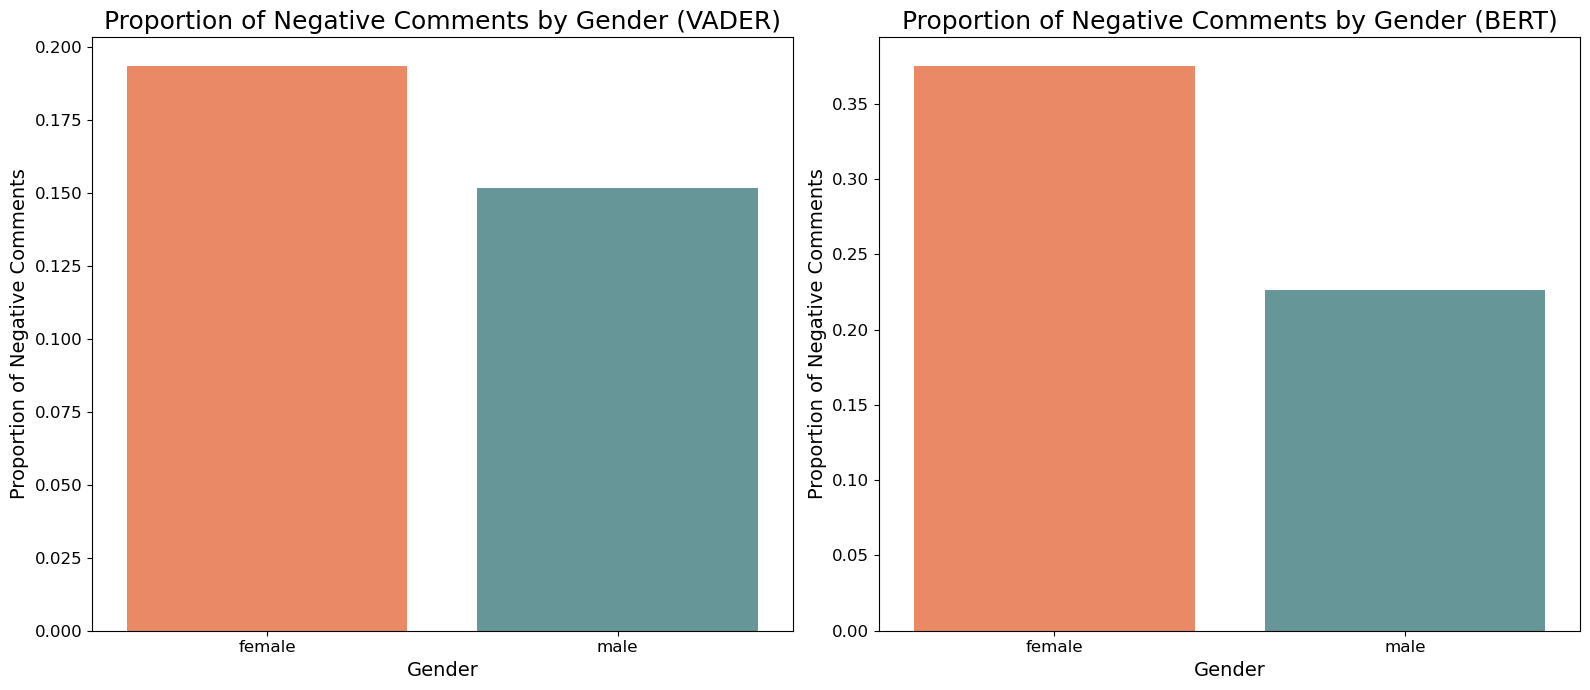

In [14]:
# Visualization of Proportion of neagtive comment by gender
# Define color palette
palette = {'male': 'cadetblue', 'female': 'coral'}

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Visualize Proportion of negativve comments using VADER
sns.barplot(x=proportions.index, y='Proportion_Negative_VADER', data=proportions, palette=palette, ax=axes[0])
axes[0].set_title('Proportion of Negative Comments by Gender (VADER)', fontsize = 18)
axes[0].set_xlabel('Gender', fontsize = 14)
axes[0].set_ylabel('Proportion of Negative Comments', fontsize = 14)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Visualize Proportion of negativve comments using BERT
sns.barplot(x=proportions.index, y='Proportion_Negative_BERT', data=proportions, palette=palette, ax=axes[1])
axes[1].set_title('Proportion of Negative Comments by Gender (BERT)', fontsize = 18)
axes[1].set_xlabel('Gender', fontsize = 14)
axes[1].set_ylabel('Proportion of Negative Comments', fontsize = 14)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig('visualizations/proportion_negative_comments_by_gender.png')
plt.show()

These plots show that for both sentiment analysis tools (VADER and BERT) female musicians receive a higher proportion of negative comments than male musicians. The difference in proportion of negative comments is larger using the sentiment analysis tool BERT. 

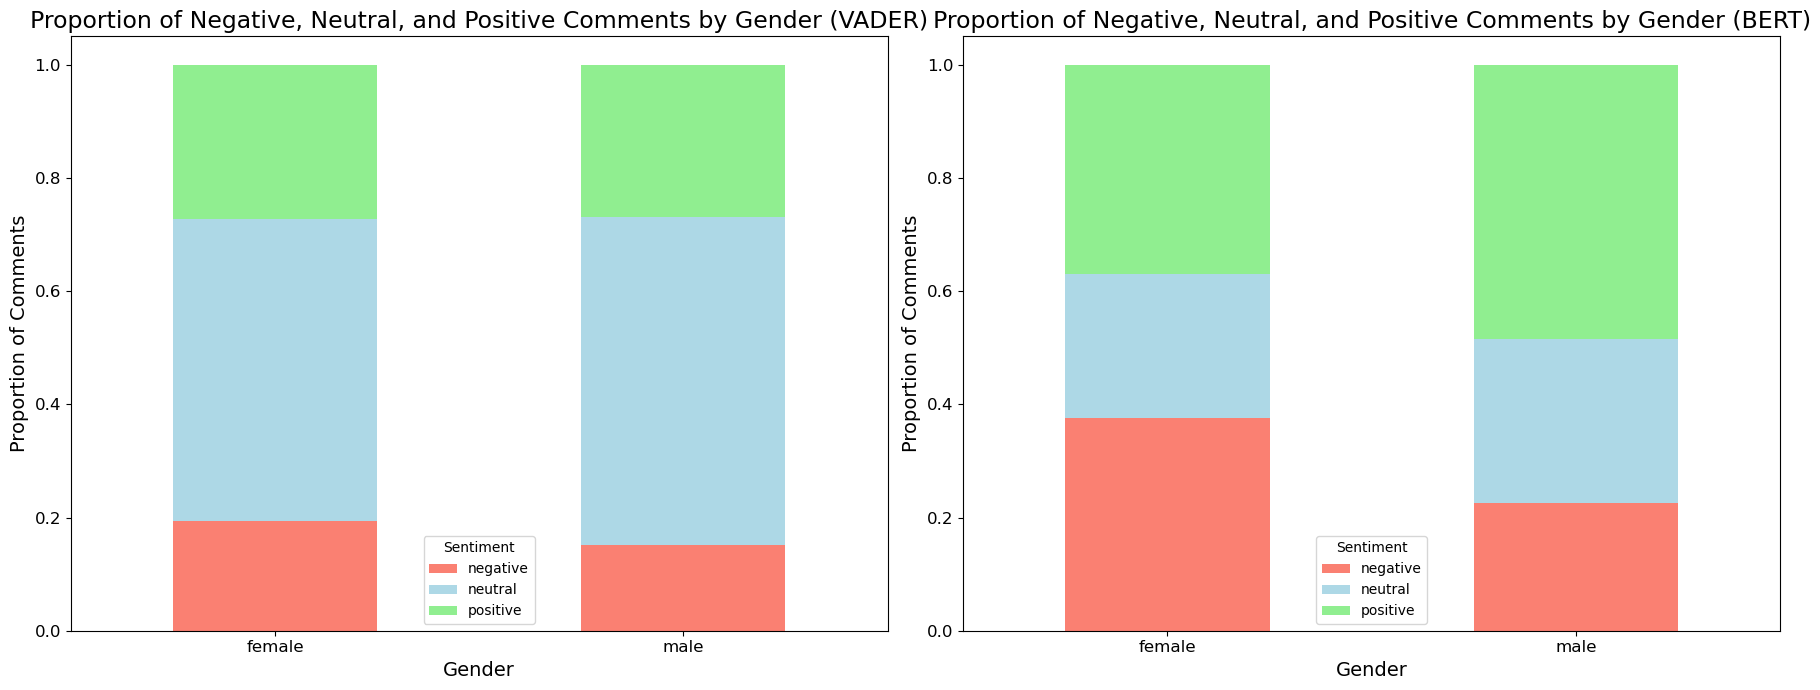

In [18]:
# Visualization of proportion of negative, neutral and positive comments by gender
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot for VADER
sentiment_proportion_vader.plot(kind='bar', stacked=True, color=['salmon', 'lightblue', 'lightgreen'], ax=axes[0])
axes[0].set_title('Proportion of Negative, Neutral, and Positive Comments by Gender (VADER)', fontsize = 17)
axes[0].set_xticks(axes[0].get_xticks()) 
axes[0].set_xticklabels(sentiment_proportion_vader.index, rotation=0) 
axes[0].set_ylabel('Proportion of Comments', fontsize = 14)
axes[0].set_xlabel('Gender', fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].legend(title='Sentiment')

# Plot for BERT
sentiment_proportion_bert.plot(kind='bar', stacked=True, color=['salmon', 'lightblue', 'lightgreen'], ax=axes[1])
axes[1].set_title('Proportion of Negative, Neutral, and Positive Comments by Gender (BERT)', fontsize = 17)
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(sentiment_proportion_bert.index, rotation=0)
axes[1].set_ylabel('Proportion of Comments', fontsize = 14)
axes[1].set_xlabel('Gender', fontsize=14)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].legend(title='Sentiment')

plt.tight_layout()
plt.savefig('visualizations/proportion_comments_by_gender.png')
plt.show()

The stacked bar charts show the proportions of sentiments of comments for male and female artists. Using the sentiment analysis tool VADER we can see that female musicians receive more negative and positive comments than male musicians and less neutral comments than male musicians. Using the sentiment analysis tool BERT female musicians receive more negative comments and less neutral and positive comments than their male counterparts.